In [272]:
import pandas as pd
import numpy as np
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime, timedelta
import yfinance as yf
import pandas_ta
from sklearn.cluster import KMeans
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import warnings
warnings.filterwarnings('ignore')

In [273]:
raw_data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

In [274]:
main_data = raw_data[0]
main_data['Symbol'] = main_data['Symbol'].str.replace('.', '-')
symbols_list = main_data['Symbol'].unique().tolist()
today = datetime.now().date()
end_date = today - timedelta(days=2)
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*10)

In [275]:
yf_df = yf.download(tickers=symbols_list, start=start_date, end=end_date).stack()
yf_df.index.names = ['date', 'ticker']
yf_df.columns = yf_df.columns.str.lower()

[*********************100%%**********************]  503 of 503 completed


In [276]:
yf_df['garman_klass_vol'] = ((np.log(yf_df['high']) - np.log(yf_df['low']))**2)/2-((2*np.log(2)-1)*(np.log(yf_df['adj close'])-np.log(yf_df['open']))**2)
yf_df['rsi'] = yf_df.groupby('ticker')['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))
yf_df['bb_low'] = yf_df.groupby('ticker')['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
yf_df['bb_mid'] = yf_df.groupby('ticker')['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
yf_df['bb_high'] = yf_df.groupby('ticker')['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

# Calculate Z-scores for each column
zscore_garman_klass_vol = (yf_df['garman_klass_vol'] - yf_df['garman_klass_vol'].mean()) / yf_df['garman_klass_vol'].std()
zscore_rsi = yf_df.groupby('ticker')['rsi'].transform(lambda x: (x - x.mean()) / x.std())
zscore_bb_low = yf_df.groupby('ticker')['bb_low'].transform(lambda x: (x - x.mean()) / x.std())
zscore_bb_mid = yf_df.groupby('ticker')['bb_mid'].transform(lambda x: (x - x.mean()) / x.std())
zscore_bb_high = yf_df.groupby('ticker')['bb_high'].transform(lambda x: (x - x.mean()) / x.std())

# Fill NaN values with Z-scores
yf_df['garman_klass_vol'].fillna(zscore_garman_klass_vol, inplace=True)
yf_df['rsi'].fillna(zscore_rsi, inplace=True)
yf_df['bb_low'].fillna(zscore_bb_low, inplace=True)
yf_df['bb_mid'].fillna(zscore_bb_mid, inplace=True)
yf_df['bb_high'].fillna(zscore_bb_high, inplace=True)

## Definiting Fynction to obtain the ATR

In [277]:
def get_atr(df):
    atr = pandas_ta.atr(high=df['high'],
                        low=df['low'],
                        close=df['close'],
                        length=14 # standard lenght for calculating ATR but it can be changed based on the requirements
                        )
    atr_mean = atr.mean()
    atr_std = atr.std()
    normalized_atr = (atr - atr_mean) / atr_std
    return normalized_atr

In [278]:
yf_df['atr'] = yf_df.groupby('ticker', group_keys=False).apply(get_atr)

## Defining Function to calculate MACD

In [279]:
def get_macd(i):
    try:
        macd = pandas_ta.macd(close=i, length= 20).iloc[:,0]
        macd_mean = macd.mean()
        macd_std = macd.std()
        normalized_macd = (macd - macd_mean) / macd_std
        return normalized_macd
    except Exception as e:
        print(f'error : {e}')
        print(f'what is causing the error {i}')

In [280]:
yf_df['macd'] = yf_df.groupby('ticker', group_keys=False)['adj close'].apply(get_macd)

error : 'NoneType' object has no attribute 'iloc'
what is causing the error date        ticker
2023-10-04  VLTO      77.800003
2023-10-05  VLTO      74.449997
2023-10-06  VLTO      77.980003
2023-10-09  VLTO      74.610001
2023-10-10  VLTO      75.000000
2023-10-11  VLTO      74.470001
2023-10-12  VLTO      74.230003
2023-10-13  VLTO      71.849998
2023-10-16  VLTO      74.209999
2023-10-17  VLTO      74.480003
2023-10-18  VLTO      72.449997
2023-10-19  VLTO      70.290001
2023-10-20  VLTO      69.930000
2023-10-23  VLTO      71.900002
2023-10-24  VLTO      72.010002
2023-10-25  VLTO      70.790001
2023-10-26  VLTO      70.000000
2023-10-27  VLTO      67.989998
2023-10-30  VLTO      68.360001
2023-10-31  VLTO      69.000000
2023-11-01  VLTO      67.510002
2023-11-02  VLTO      70.279999
2023-11-03  VLTO      70.800003
Name: VLTO, dtype: float64


## Getting Dollar Volume

In [281]:
yf_df['dollar_v'] = (yf_df['adj close'] * yf_df['volume']) / 1e6

In [282]:
yf_df

adj close       close        high         low        open  \
date       ticker                                                               
2013-11-06 A        33.516273   36.509300   36.709583   36.337624   36.616596   
           AAL      21.117409   22.400000   23.260000   21.900000   23.260000   
           AAPL     16.331705   18.604286   18.745001   18.507143   18.719643   
           ABBV     31.899233   48.049999   48.740002   48.000000   48.500000   
           ABT      30.968466   37.560001   37.799999   37.040001   37.450001   
...                       ...         ...         ...         ...         ...   
2023-11-03 YUM     126.339996  126.339996  126.849998  123.889999  124.260002   
           ZBH     108.750000  108.750000  111.309998  107.779999  110.690002   
           ZBRA    214.300003  214.300003  217.139999  210.869995  210.869995   
           ZION     34.759998   34.759998   35.080002   34.279999   34.389999   
           ZTS     162.229996  162.229996  164.720001  159.369995  164.250000   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2013-11-06 A         1997323.0         -0.002972        NaN       NaN   
           AAL       8827100.0         -0.001793        NaN       NaN   
           AAPL    223375600.0         -0.007112        NaN       NaN   
           ABBV      4308100.0         -0.067695        NaN       NaN   
           ABT       7082400.0         -0.013744        NaN       NaN   
...                        ...               ...        ...       ...   
2023-11-03 YUM       1754600.0          0.000172  57.873473  4.759734   
           ZBH       2140100.0          0.000399  47.209755  4.621534   
           ZBRA       540800.0          0.000329  44.828316  5.288230   
           ZION      2598900.0          0.000222  54.872942  3.365401   
           ZTS       1974700.0          0.000486  41.686312  5.026819   

                     bb_mid   bb_high       atr      macd     dollar_v  
date       ticker                                                       
2013-11-06 A            NaN       NaN       NaN       NaN    66.942824  
           AAL          NaN       NaN       NaN       NaN   186.405479  
           AAPL         NaN       NaN       NaN       NaN  3648.104424  
           ABBV         NaN       NaN       NaN       NaN   137.425085  
           ABT          NaN       NaN       NaN       NaN   219.331062  
...                     ...       ...       ...       ...          ...  
2023-11-03 YUM     4.795624  4.831515  0.839335 -0.266736   221.676158  
           ZBH     4.669839  4.718144  0.050571 -0.809727   232.735875  
           ZBRA    5.348591  5.408953  0.435375 -1.077785   115.893442  
           ZION    3.515197  3.664993  0.480089 -0.664087    90.337760  
           ZTS     5.118009  5.209199  1.266563 -2.732920   320.355573  

[1234504 rows x 14 columns]

## Aggregate to monthly level and filter top 150 most liquid stocks to reduce training time

In [283]:
last_columns = [c for c in yf_df.columns.unique(0) if c not in ['dollar_v', 'volume', 'open', 'high', 'low', 'close']]
df = (pd.concat([yf_df.unstack('ticker')['dollar_v'].resample('M').mean().stack('ticker').to_frame('dollar_v'),
                yf_df.unstack()[last_columns].resample('M').last().stack('ticker')], axis=1)).dropna()

### calculating 7-years rolling average of dollar volume

In [284]:
df['dollar_v'] = (df.loc[:, 'dollar_v'].unstack('ticker').rolling(7*12, min_periods=12).mean().stack())
df['dv_rank'] = (df.groupby('date')['dollar_v'].rank(ascending=False))
df = df[df['dv_rank']<=150].drop(['dollar_v', 'dv_rank'], axis=1)

## Getting the monthly returns

In [285]:
# identifying lags and clipping outliers
def get_returns(data):
    threshold = 0.005
    lags = [1,2,3,6,9,12]
    for lag in lags:
        data[f'return_{lag}_m'] = (data['adj close']
                                   .pct_change(lag)
                                   .pipe(lambda x: x.clip(lower=x.quantile(threshold),
                                                          upper=x.quantile(1-threshold)))
                                   .add(1)
                                   .pow(1/lag)
                                   .sub(1) 
                                   )
    return data

df = df.groupby('ticker', group_keys=False).apply(get_returns).dropna()

## Using Fama-French factors to assess how assets are affected by market risk, size, value, profitability, and investment strategies through regression analysis provides valuable insights into their exposure to these influential factors.

In [286]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
               'famafrench',
               start='2010')[0]
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'

In [287]:
factor_data = factor_data.join(df['return_1_m']).sort_index()

In [288]:
obs = factor_data.groupby('ticker').size()
vs = obs[obs >=10]
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(vs.index)]

### calculating rolling factor Betas.

In [289]:
betas = (factor_data.groupby('ticker', group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1_m'],
                                     exog=sm.add_constant(x.drop('return_1_m', axis=1)),
                                     window=min(36, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1))
         )


In [290]:
df = (df.join(betas.groupby('ticker').shift()))

In [291]:
df

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2015-11-30 AAL      39.429939         -0.000966  40.880524  3.672028   
           AAPL     26.960350         -0.003027  53.592917  3.285478   
           ABBV     41.160313         -0.053947  46.995736  3.745051   
           ABT      38.669403         -0.009962  52.539197  3.665571   
           ACN      94.345894         -0.006636  57.567283  4.525864   
...                       ...               ...        ...       ...   
2023-11-30 WBA      22.110001          0.000287  48.247759  3.054986   
           WFC      41.619999          0.000136  56.480087  3.662564   
           WMT     164.660004          0.000038  57.973912  5.058578   
           WYNN     92.760002          0.000436  52.198627  4.455907   
           XOM     107.779999          0.000204  45.660313  4.656301   

                     bb_mid   bb_high       atr      macd  return_1_m  \
date       ticker                                                       
2015-11-30 AAL     3.749832  3.827636  0.025631 -0.721109   -0.105388   
           AAPL    3.328796  3.372114 -0.794380 -0.160235   -0.005804   
           ABBV    3.793320  3.841588 -0.331936  0.060418   -0.023510   
           ABT     3.687430  3.709289 -0.842137  0.209679    0.002679   
           ACN     4.550195  4.574525 -0.916036  0.042557    0.000186   
...                     ...       ...       ...       ...         ...   
2023-11-30 WBA     3.130526  3.206066 -1.285948 -0.338453    0.048862   
           WFC     3.709973  3.757382 -0.247609 -0.193921    0.055847   
           WMT     5.089203  5.119829  0.480552  0.592346    0.007649   
           WYNN    4.510003  4.564099 -1.170041 -0.244472    0.056733   
           XOM     4.698632  4.740963  1.319586 -1.425959    0.018233   

                   return_2_m  return_3_m  return_6_m  return_9_m  \
date       ticker                                                   
2015-11-30 AAL       0.031927    0.019861   -0.003670   -0.015729   
           AAPL      0.037844    0.017564   -0.014506   -0.007686   
           ABBV      0.038557   -0.020295   -0.019629   -0.001640   
           ABT       0.059879   -0.000804   -0.011291   -0.004146   
           ACN       0.050195    0.047565    0.020338    0.022024   
...                       ...         ...         ...         ...   
2023-11-30 WBA      -0.002927   -0.044057   -0.048706   -0.047863   
           WFC       0.013746    0.005628    0.010240   -0.010192   
           WMT       0.014680    0.004185    0.019842    0.017775   
           WYNN      0.001892   -0.029186   -0.009856   -0.016597   
           XOM      -0.042580   -0.010329    0.010306   -0.000307   

                   return_12_m  Mkt-RF  SMB  HML  RMW  CMA  RF  
date       ticker                                               
2015-11-30 AAL       -0.012729     NaN  NaN  NaN  NaN  NaN NaN  
           AAPL       0.000966     NaN  NaN  NaN  NaN  NaN NaN  
           ABBV      -0.011735     NaN  NaN  NaN  NaN  NaN NaN  
           ABT        0.002517     NaN  NaN  NaN  NaN  NaN NaN  
           ACN        0.020034     NaN  NaN  NaN  NaN  NaN NaN  
...                        ...     ...  ...  ...  ...  ...  ..  
2023-11-30 WBA       -0.043858     NaN  NaN  NaN  NaN  NaN NaN  
           WFC       -0.009188     NaN  NaN  NaN  NaN  NaN NaN  
           WMT        0.007733     NaN  NaN  NaN  NaN  NaN NaN  
           WYNN       0.009054     NaN  NaN  NaN  NaN  NaN NaN  
           XOM       -0.000669     NaN  NaN  NaN  NaN  NaN NaN  

[14094 rows x 20 columns]

In [292]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'RF', 'CMA']
df.loc[:, factors] = df.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
df = df.dropna()


In [293]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13437 entries, (Timestamp('2015-11-30 00:00:00'), 'AAL') to (Timestamp('2023-11-30 00:00:00'), 'XOM')
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   adj close         13437 non-null  float64
 1   garman_klass_vol  13437 non-null  float64
 2   rsi               13437 non-null  float64
 3   bb_low            13437 non-null  float64
 4   bb_mid            13437 non-null  float64
 5   bb_high           13437 non-null  float64
 6   atr               13437 non-null  float64
 7   macd              13437 non-null  float64
 8   return_1_m        13437 non-null  float64
 9   return_2_m        13437 non-null  float64
 10  return_3_m        13437 non-null  float64
 11  return_6_m        13437 non-null  float64
 12  return_9_m        13437 non-null  float64
 13  return_12_m       13437 non-null  float64
 14  Mkt-RF            13437 non-null  float64
 15  SMB        

## Applying K-Means for clustring the data

In [294]:
target_rsi = [30, 55, 75, 85]

init_cent = np.zeros((len(target_rsi), 20))
init_cent[:,2] = target_rsi

def get_clusters(df):
    kmeans = KMeans(n_clusters=4, random_state=0, init=init_cent).fit(df)  # Clustering based on the first 3 columns
    
    df['clusters'] = kmeans.labels_
    
    # Define your targeted RSI ranges for each cluster
    targeted_rsi_ranges = {
        0: (30, 55),  # Cluster 0: RSI between 30 and 55
        1: (56, 75),  # Cluster 1: RSI between 56 and 75
        2: (76, 85),  # Cluster 2: RSI between 76 and 85
        3: (86, float('inf'))  # Cluster 3: RSI greater than or equal to 86
    }

    # Filter the DataFrame to include only data within the targeted RSI ranges
    for cluster_label, (min_rsi, max_rsi) in targeted_rsi_ranges.items():
        cluster_df = df[df['clusters'] == cluster_label]
        cluster_df = cluster_df[(cluster_df.iloc[:, 2] >= min_rsi) & (cluster_df.iloc[:, 2] < max_rsi)]
        print(f"Cluster {cluster_label} - RSI range {min_rsi} to {max_rsi}:")
        # print(cluster_df)
    
    return df

In [295]:
df = df.dropna().groupby('date', group_keys=False).apply(get_clusters)

Cluster 0 - RSI range 30 to 55:
Cluster 1 - RSI range 56 to 75:
Cluster 2 - RSI range 76 to 85:
Cluster 3 - RSI range 86 to inf:
Cluster 0 - RSI range 30 to 55:
Cluster 1 - RSI range 56 to 75:
Cluster 2 - RSI range 76 to 85:
Cluster 3 - RSI range 86 to inf:
Cluster 0 - RSI range 30 to 55:
Cluster 1 - RSI range 56 to 75:
Cluster 2 - RSI range 76 to 85:
Cluster 3 - RSI range 86 to inf:
Cluster 0 - RSI range 30 to 55:
Cluster 1 - RSI range 56 to 75:
Cluster 2 - RSI range 76 to 85:
Cluster 3 - RSI range 86 to inf:
Cluster 0 - RSI range 30 to 55:
Cluster 1 - RSI range 56 to 75:
Cluster 2 - RSI range 76 to 85:
Cluster 3 - RSI range 86 to inf:
Cluster 0 - RSI range 30 to 55:
Cluster 1 - RSI range 56 to 75:
Cluster 2 - RSI range 76 to 85:
Cluster 3 - RSI range 86 to inf:
Cluster 0 - RSI range 30 to 55:
Cluster 1 - RSI range 56 to 75:
Cluster 2 - RSI range 76 to 85:
Cluster 3 - RSI range 86 to inf:
Cluster 0 - RSI range 30 to 55:
Cluster 1 - RSI range 56 to 75:
Cluster 2 - RSI range 76 to 85:
C

In [296]:
df['clusters'].unique()

array([2, 1, 3, 0], dtype=int32)

In [297]:
def plot_clusters(df, x_index, y_index, x_label, y_label):
    cluster_0 = df[df['clusters'] == 0]
    cluster_1 = df[df['clusters'] == 1]
    cluster_2 = df[df['clusters'] == 2]
    cluster_3 = df[df['clusters'] == 3]

    # Define custom cluster ranges and colors
    cluster_ranges = [(30, 54), (55, 74), (75, 84), (85, 100)]
    cluster_colors = ['red', 'green', 'blue', 'black']

    for i in range(4):
        range_start, range_end = cluster_ranges[i]
        color = cluster_colors[i]
        cluster_df = df[(df['clusters'] == i) & (df['rsi'] >= range_start) & (df['rsi'] <= range_end)]
        plt.scatter(cluster_df.iloc[:, x_index], cluster_df.iloc[:, y_index], color=color, label=f'Cluster {i} (RSI {range_start}-{range_end})')

    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.legend()
    plt.show()
    return

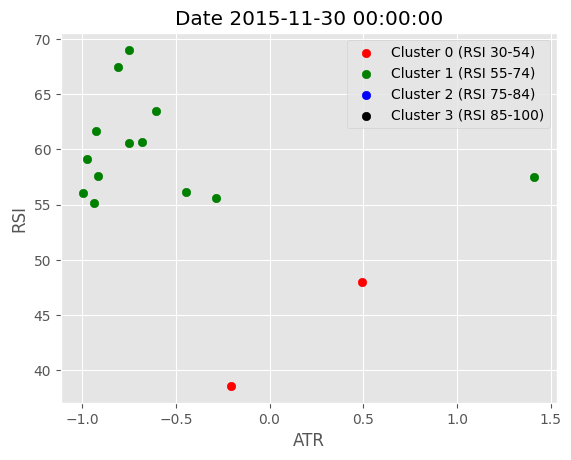

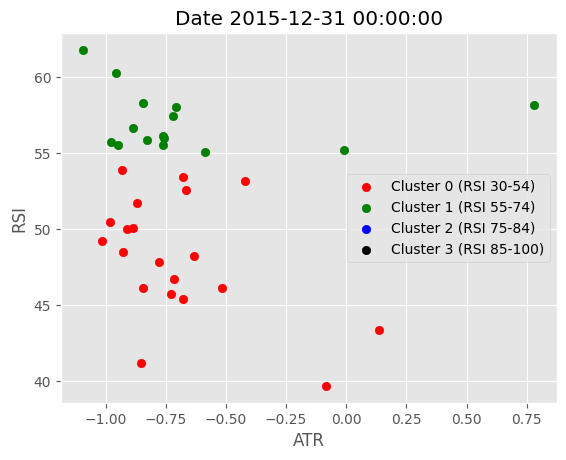

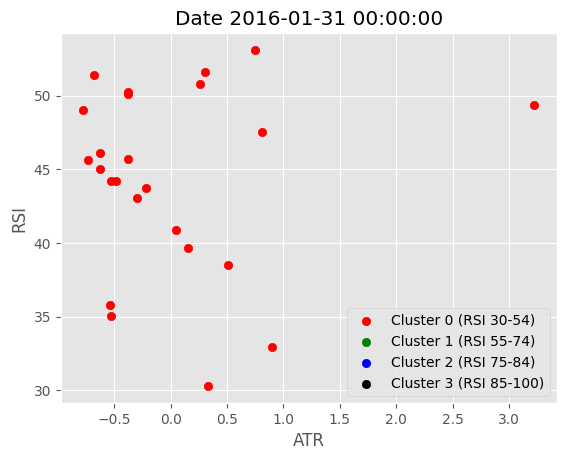

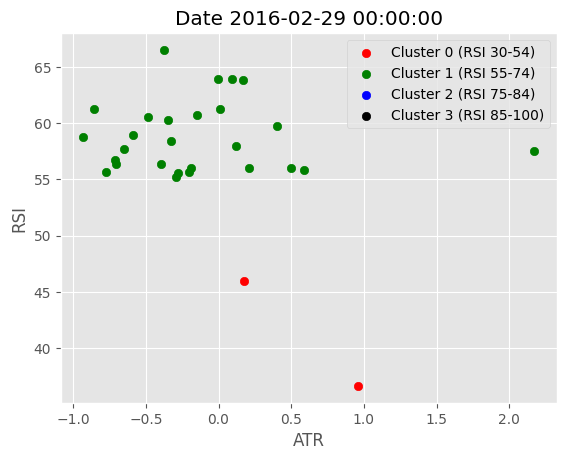

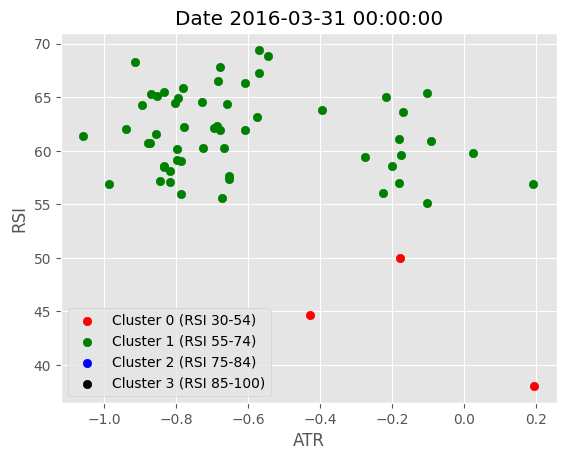

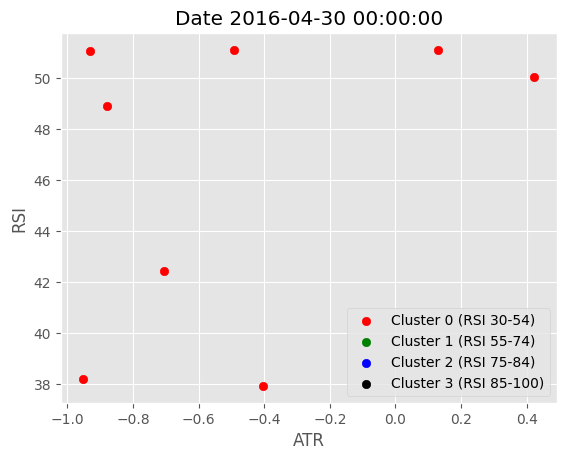

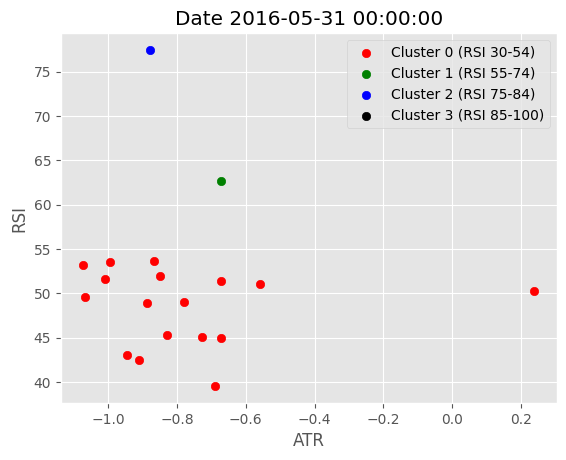

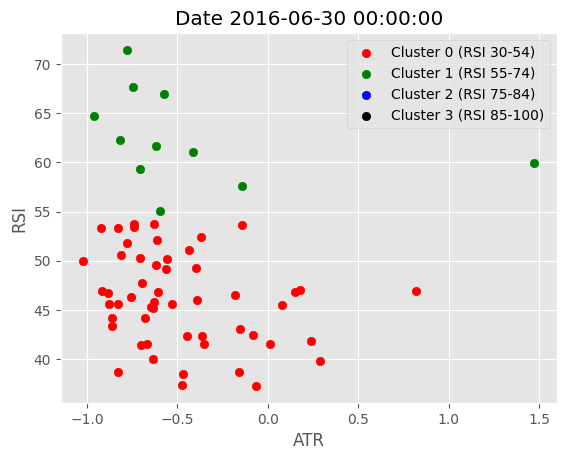

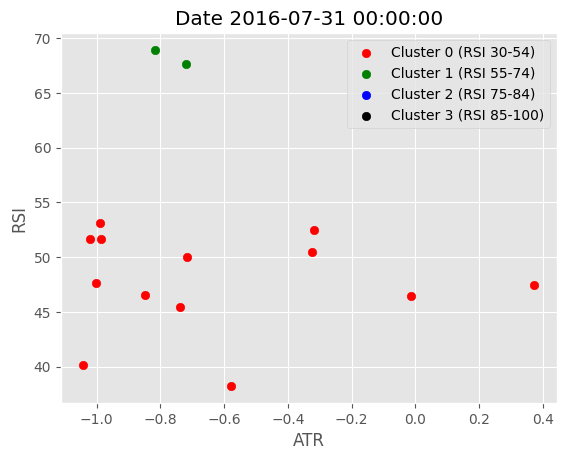

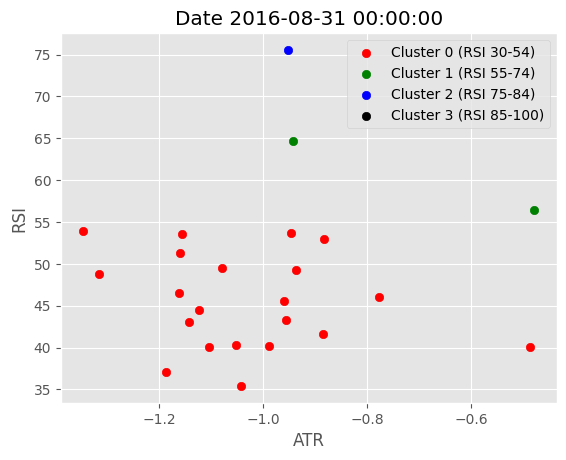

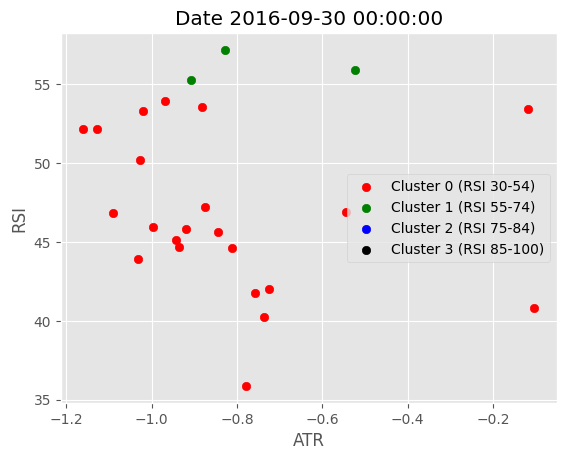

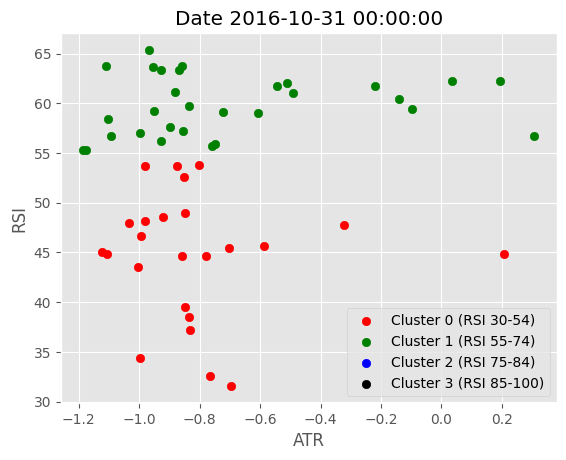

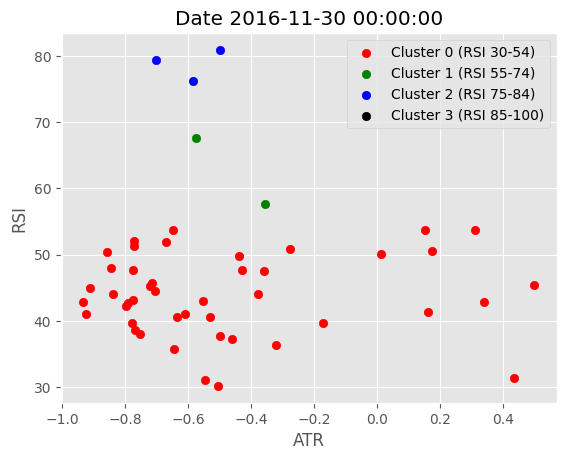

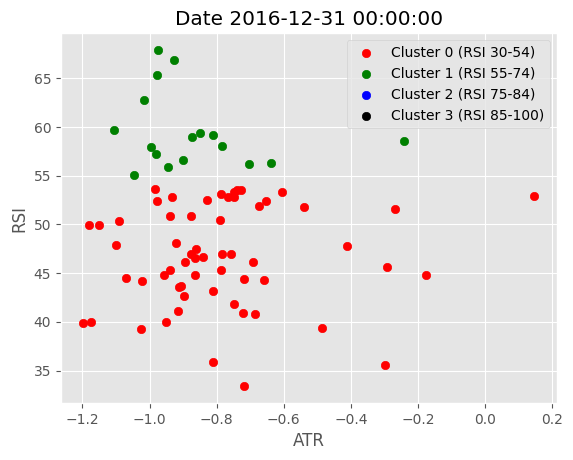

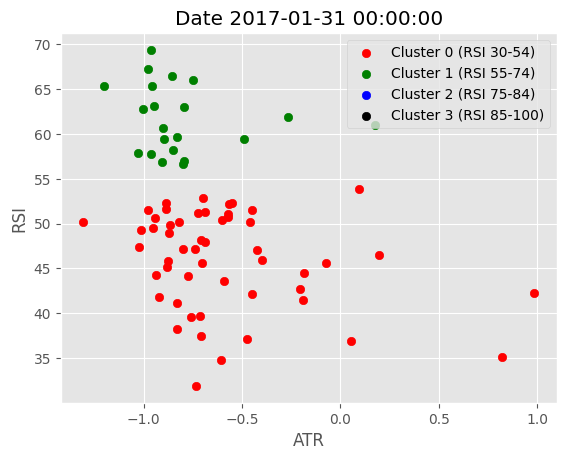

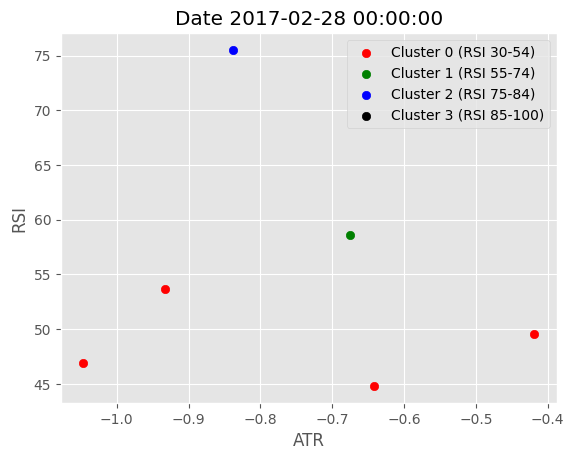

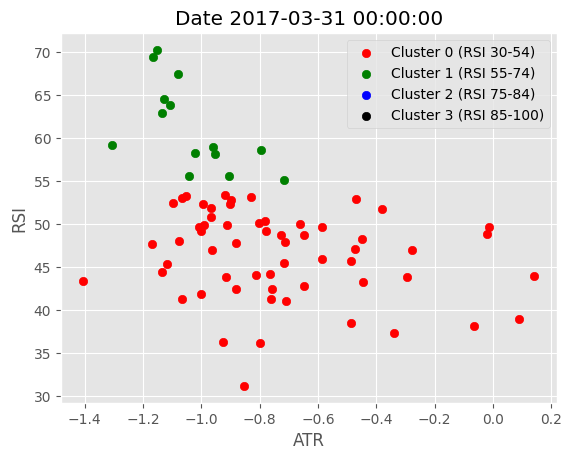

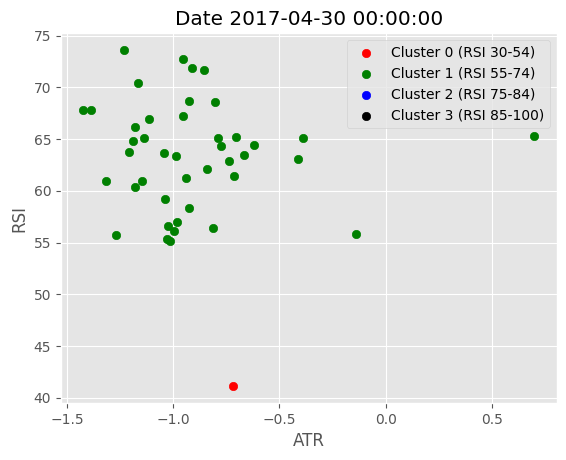

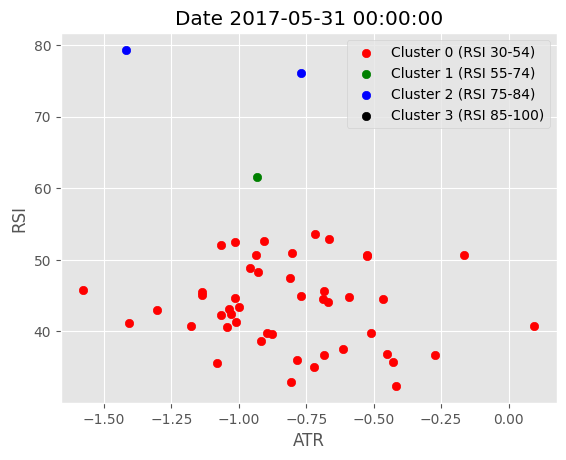

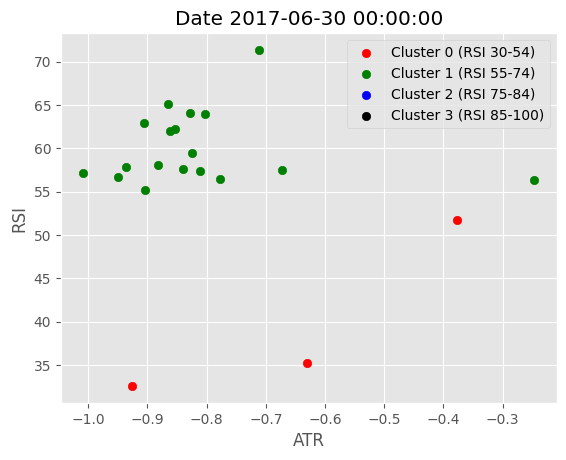

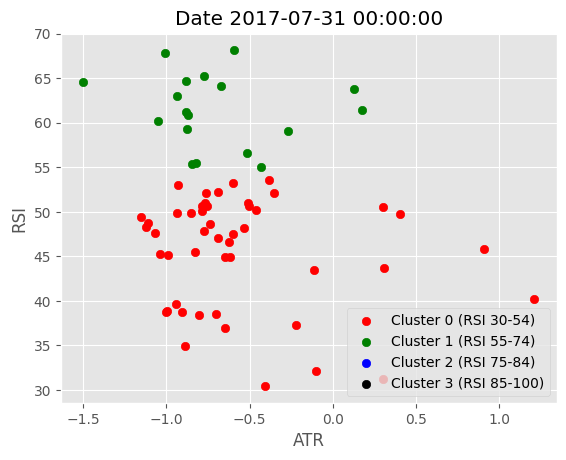

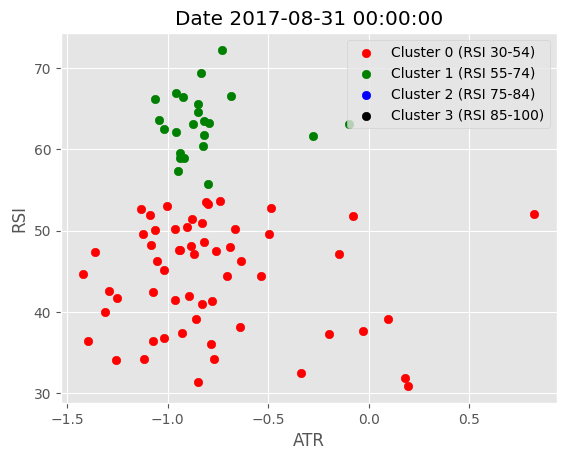

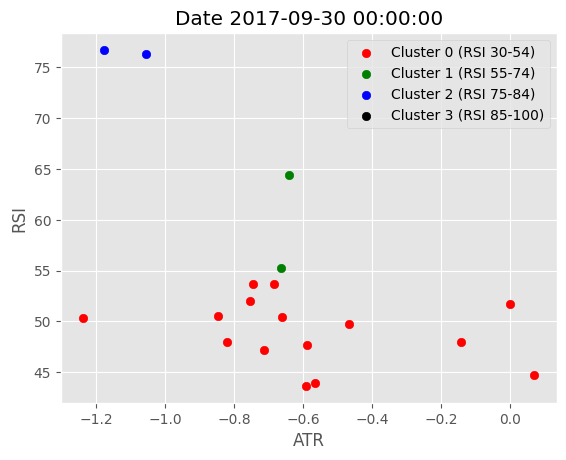

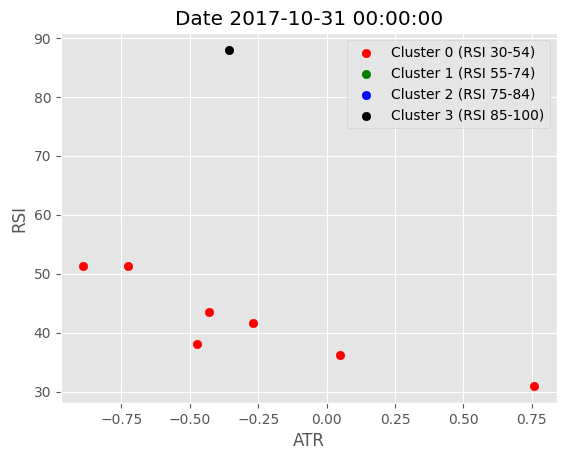

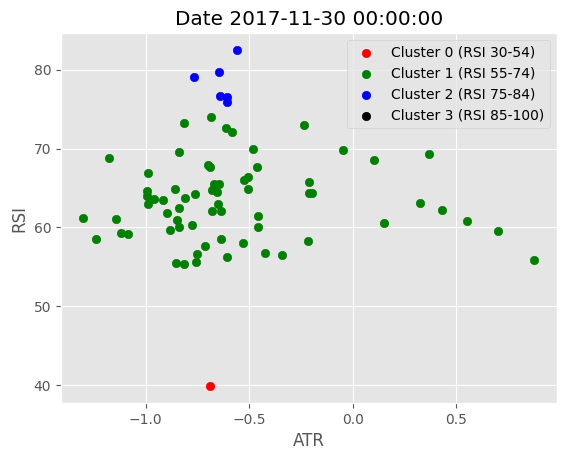

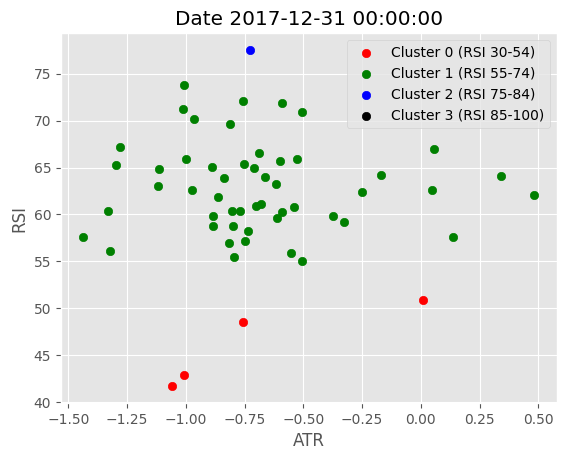

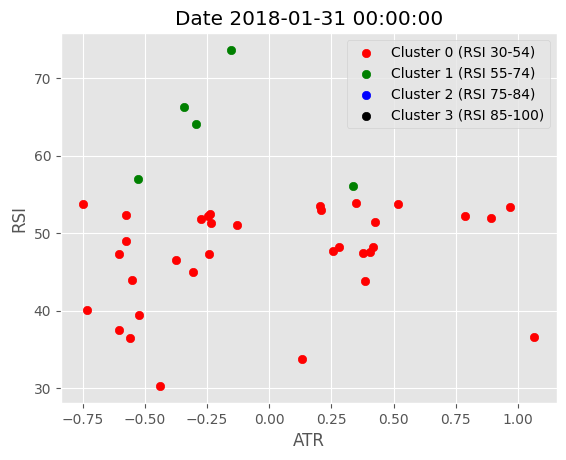

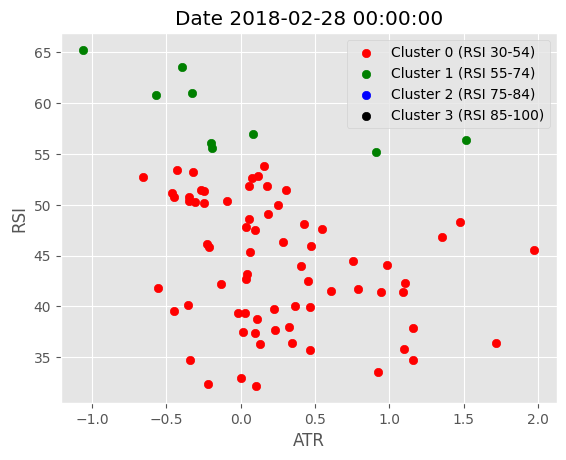

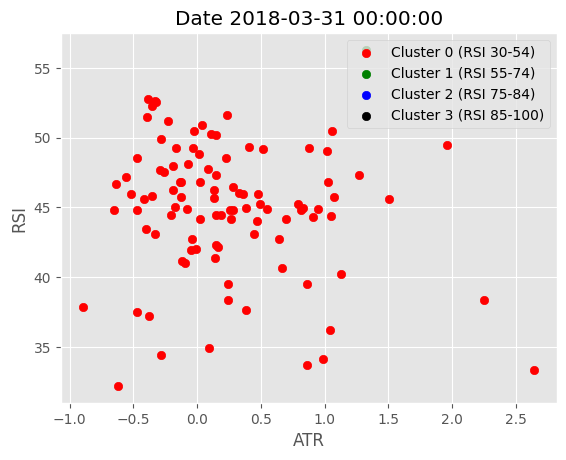

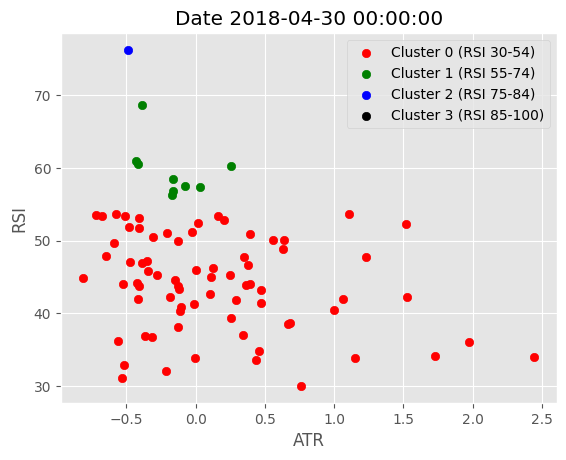

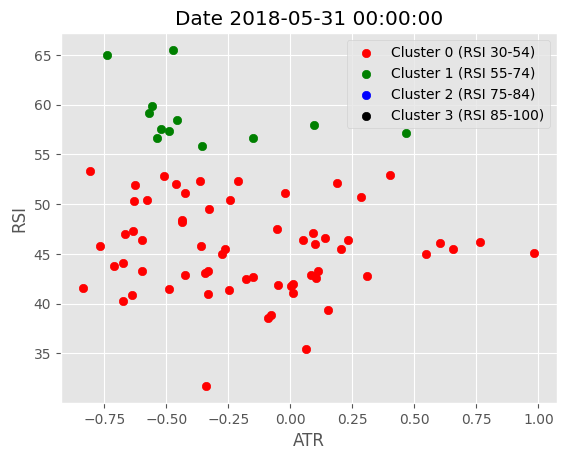

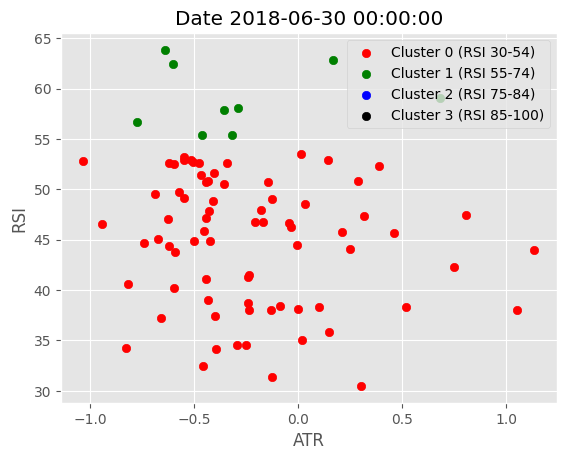

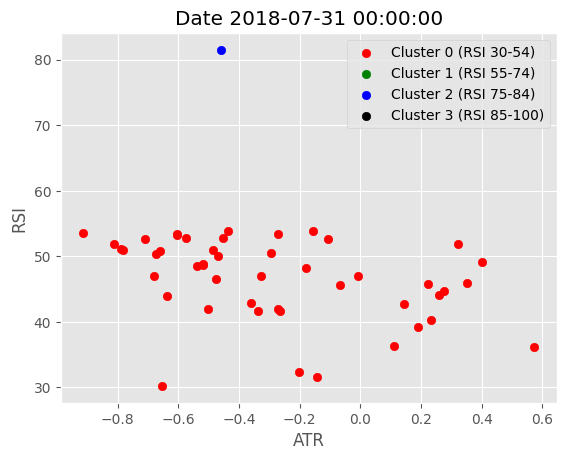

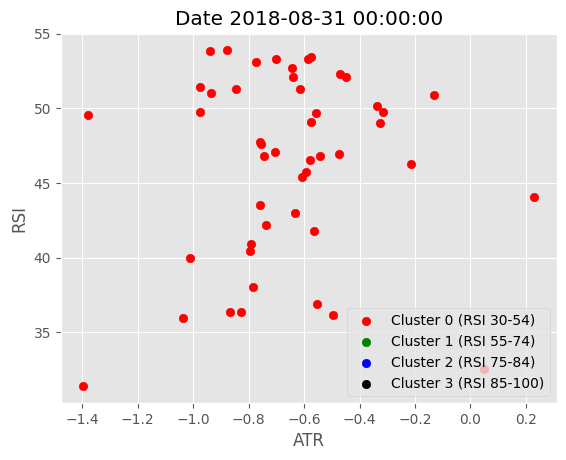

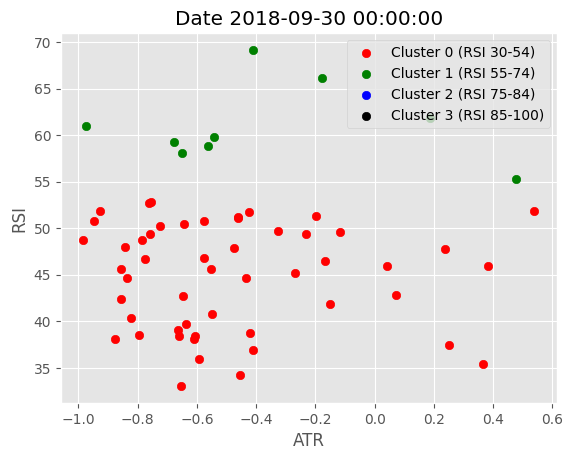

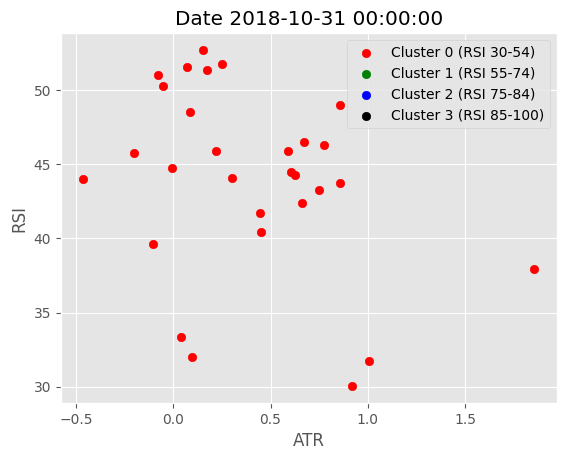

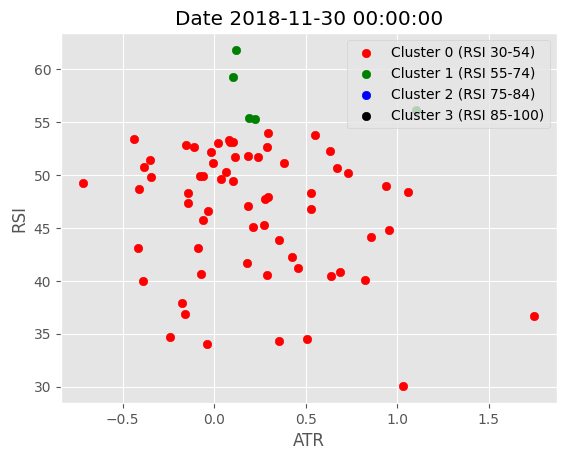

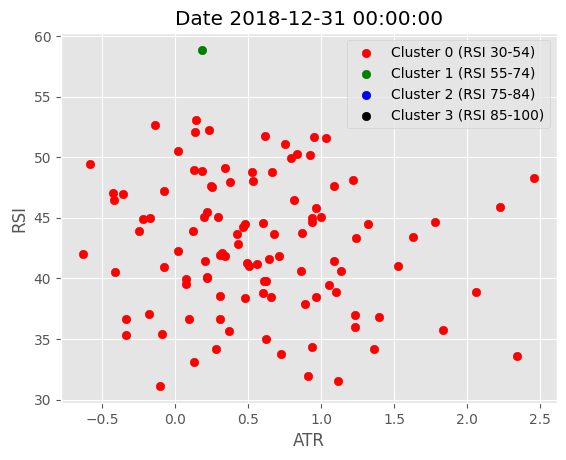

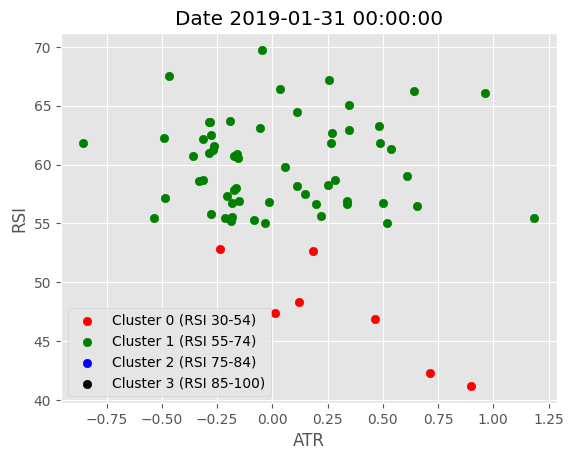

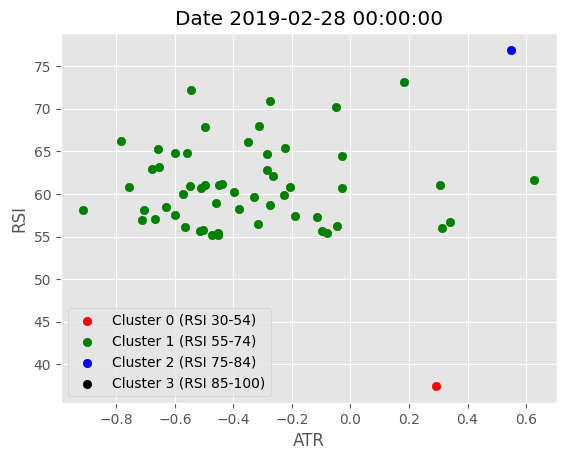

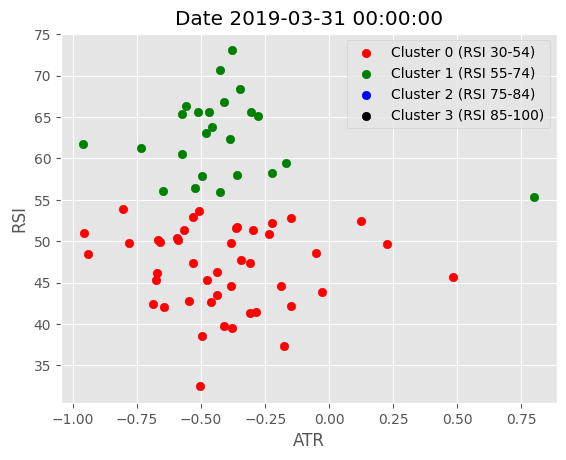

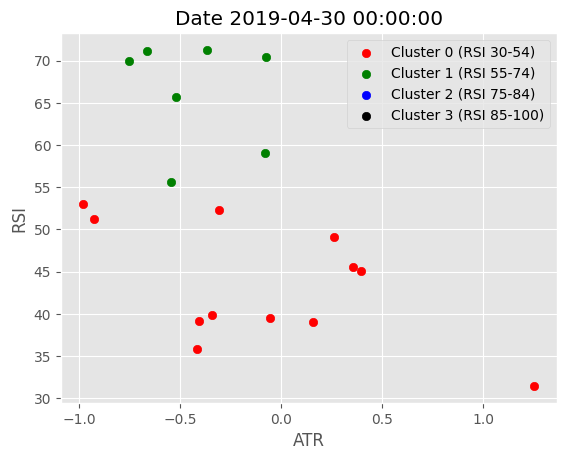

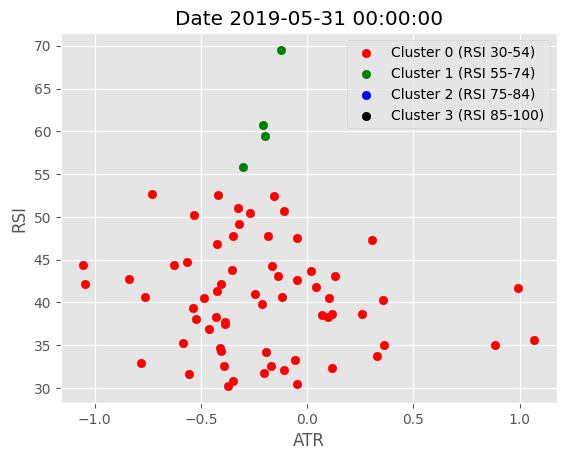

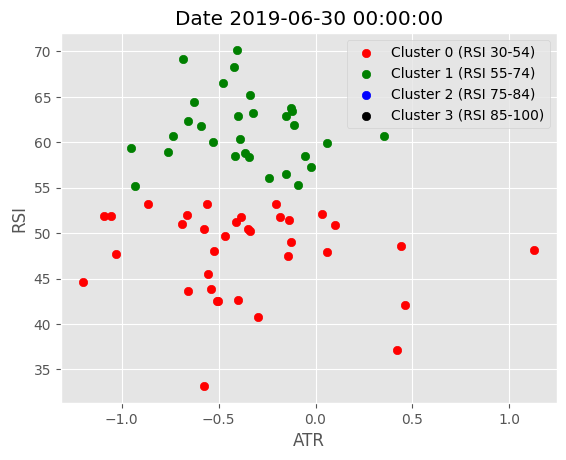

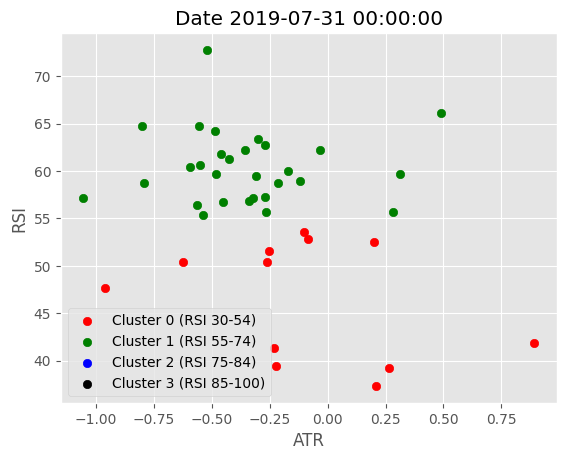

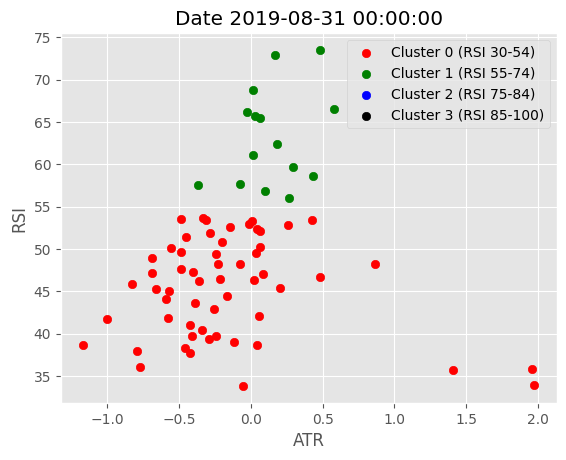

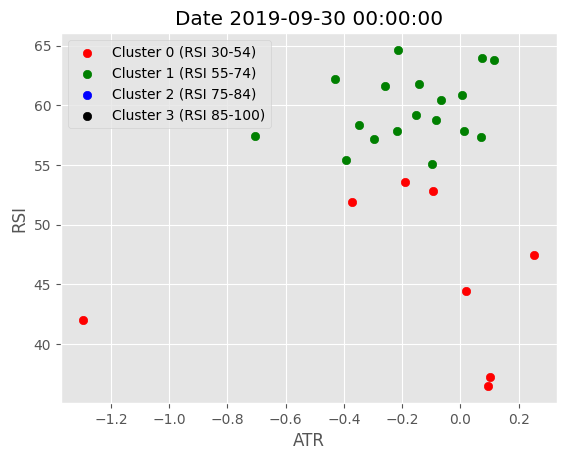

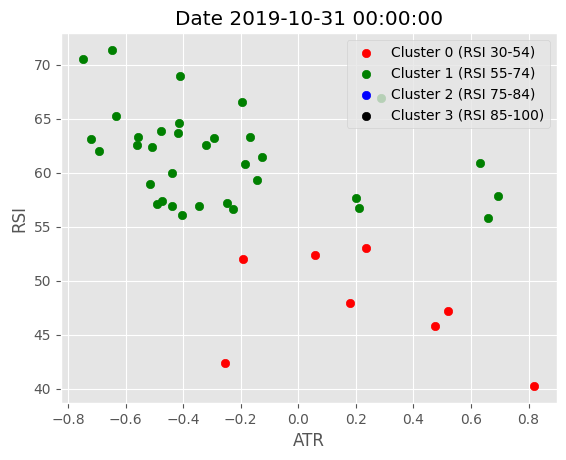

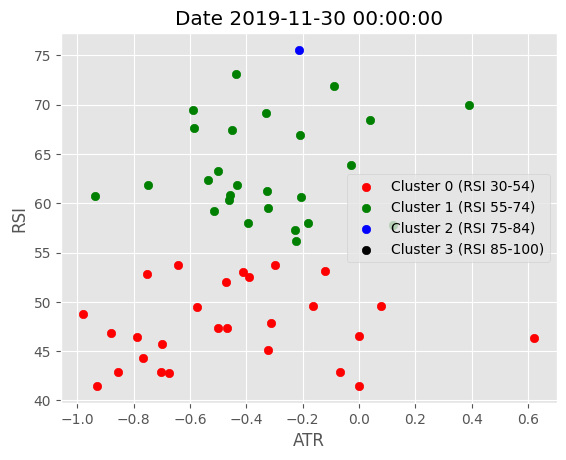

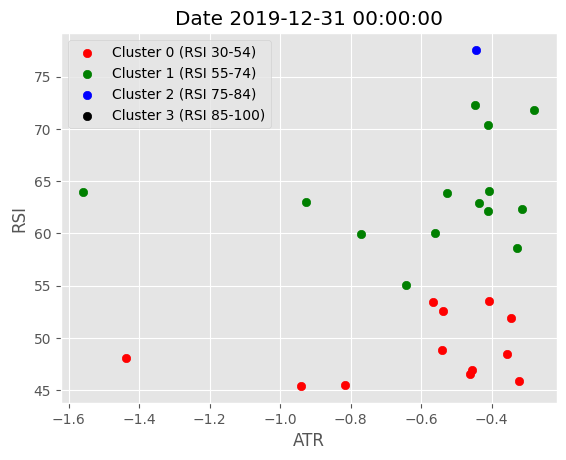

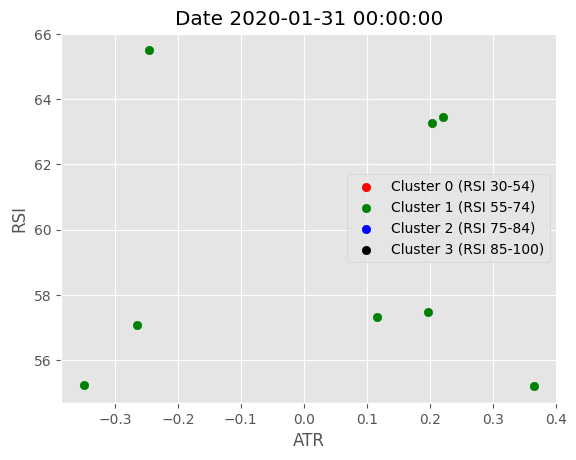

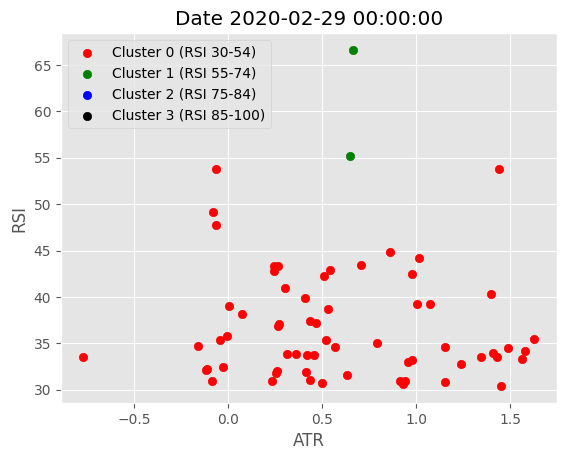

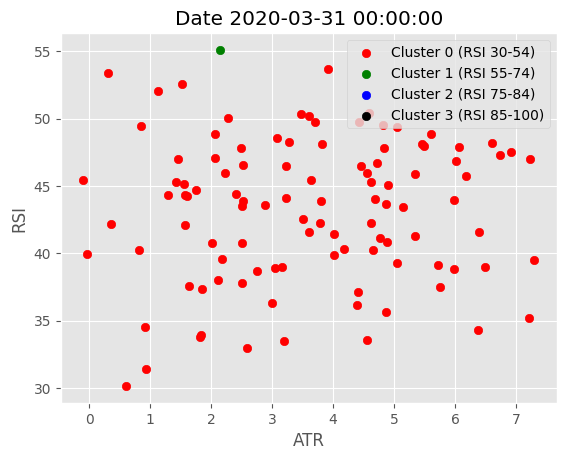

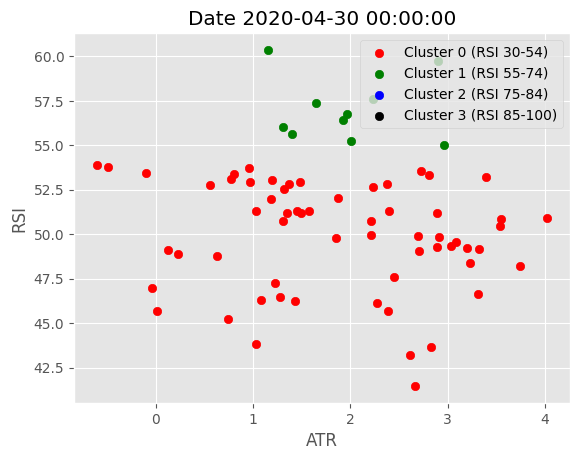

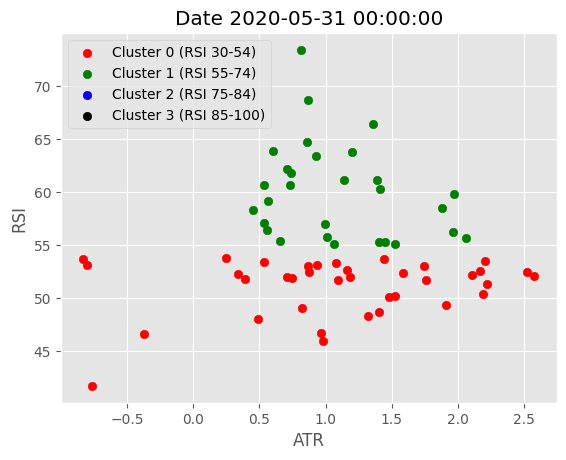

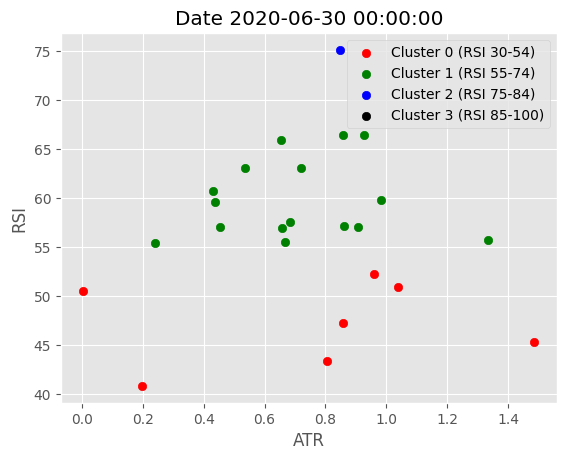

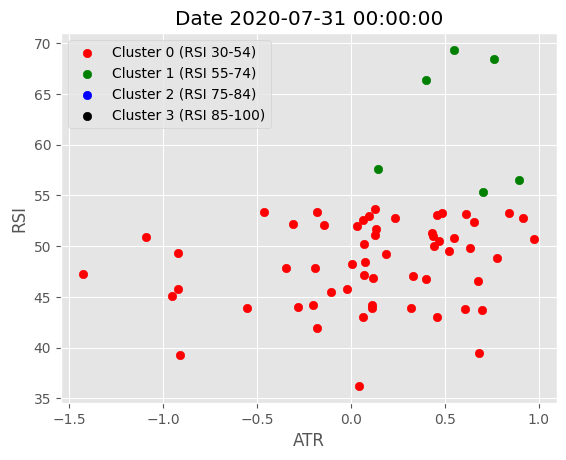

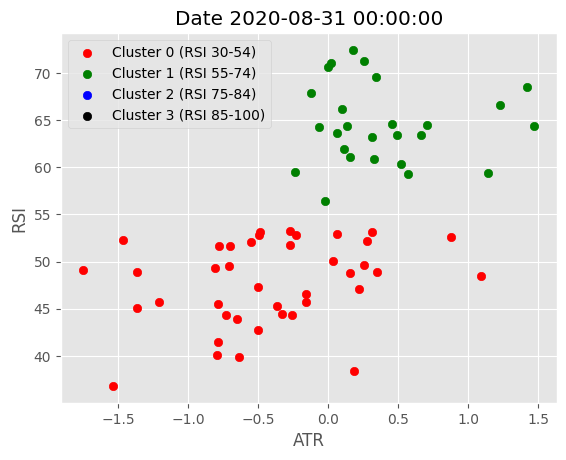

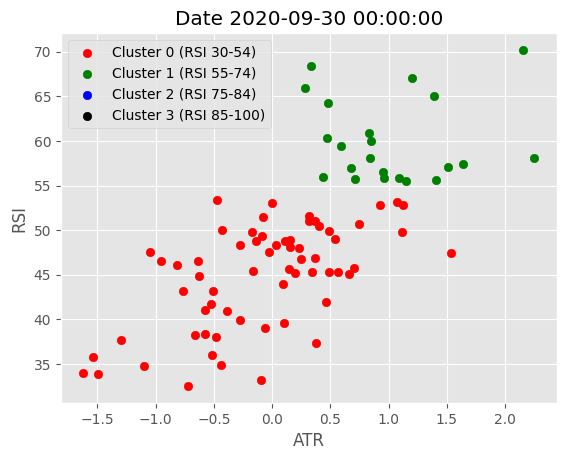

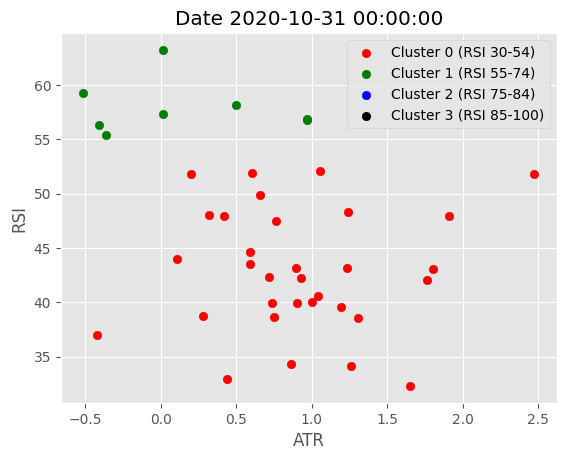

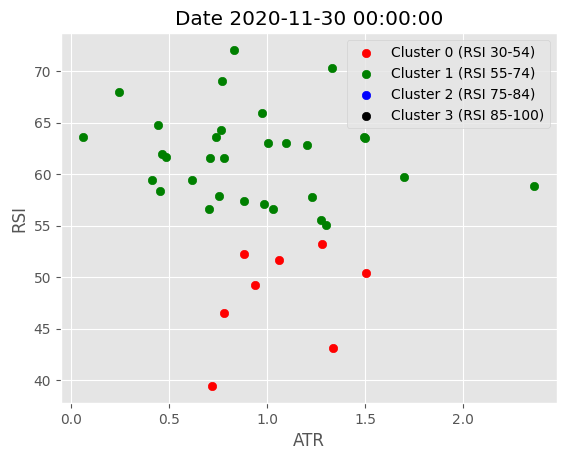

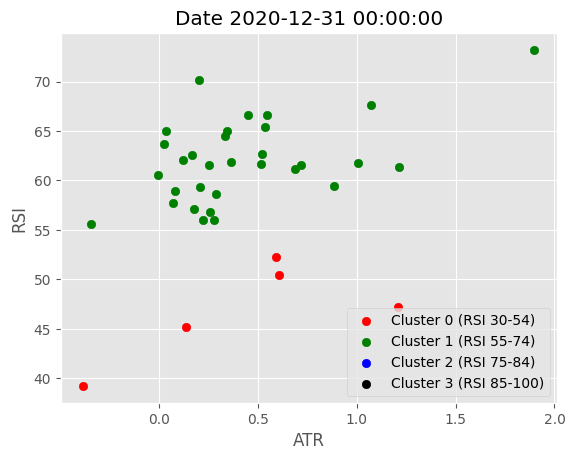

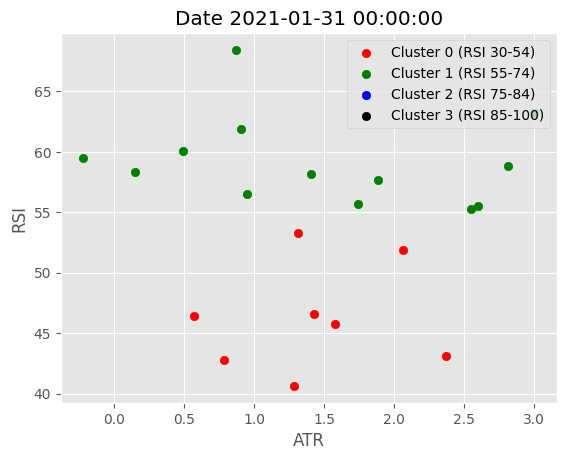

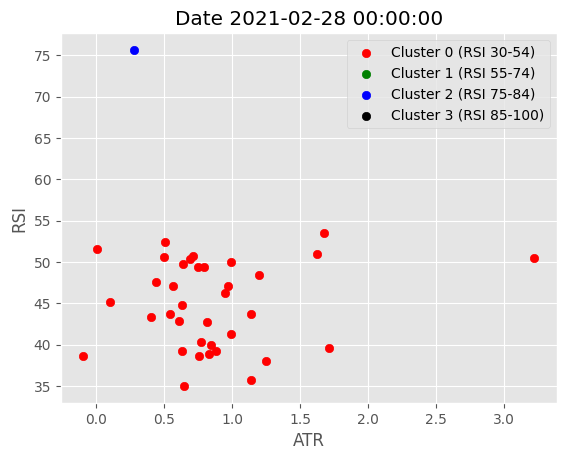

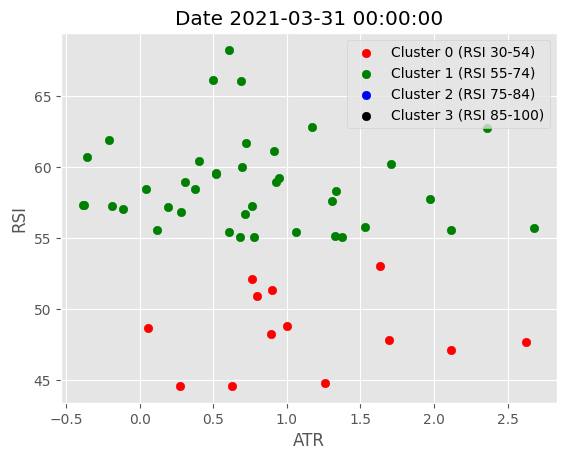

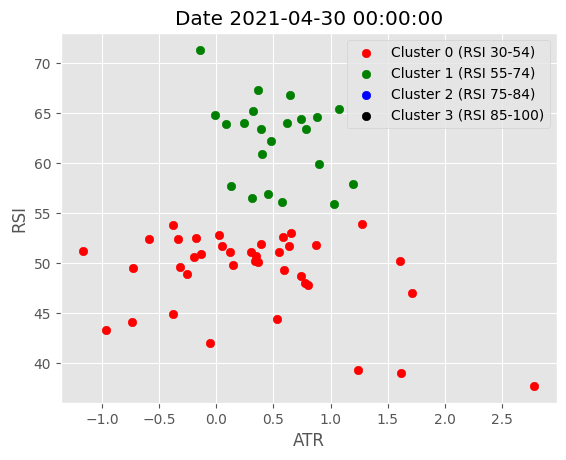

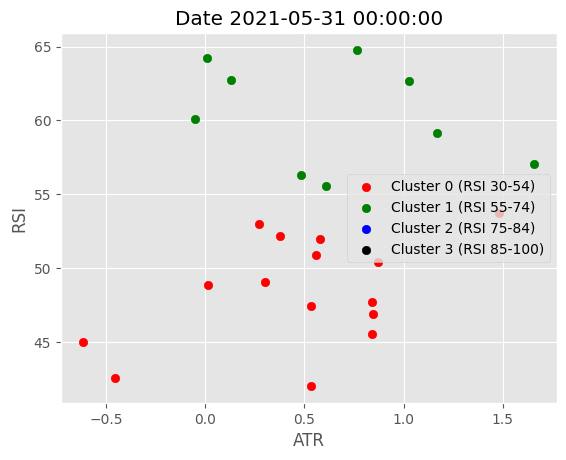

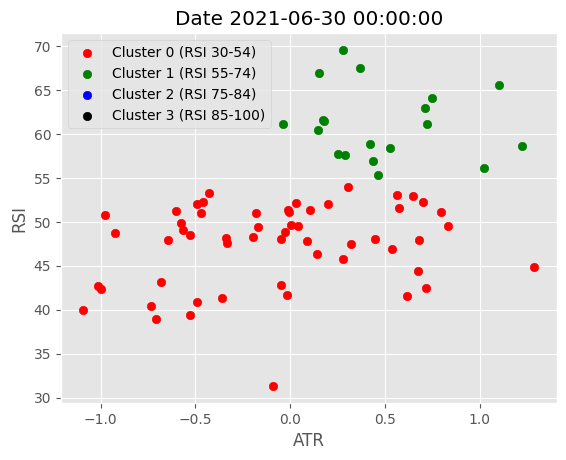

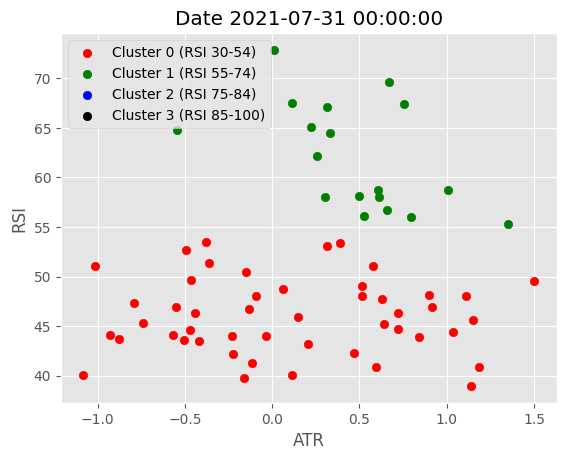

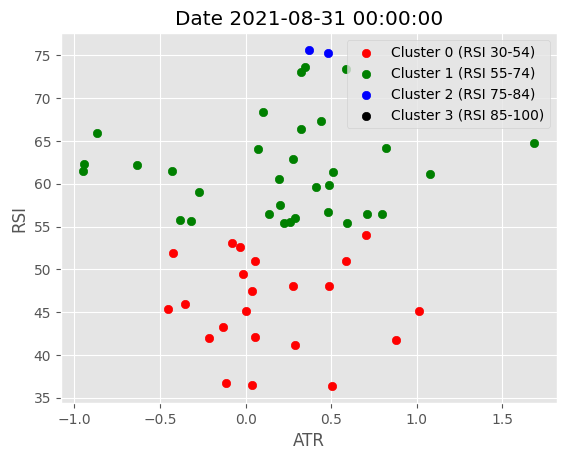

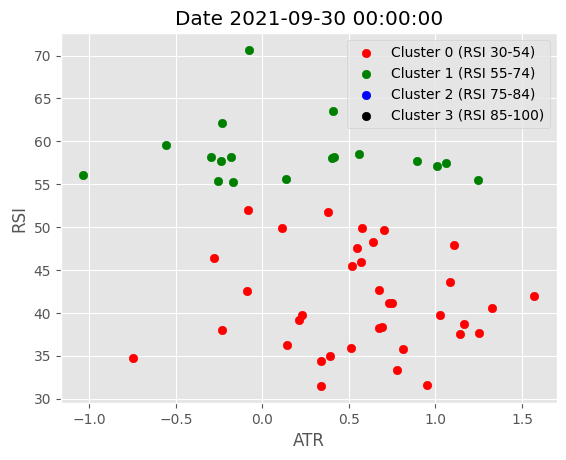

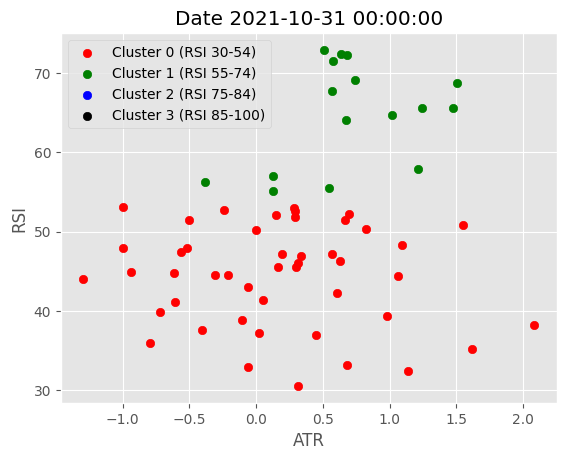

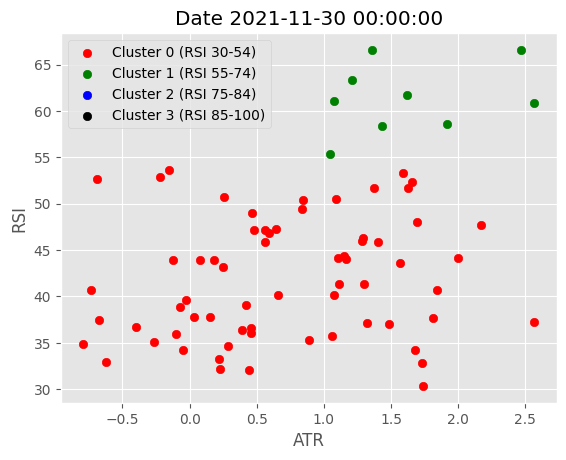

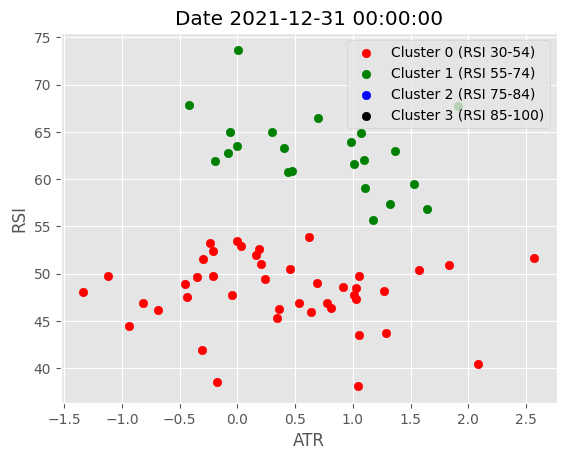

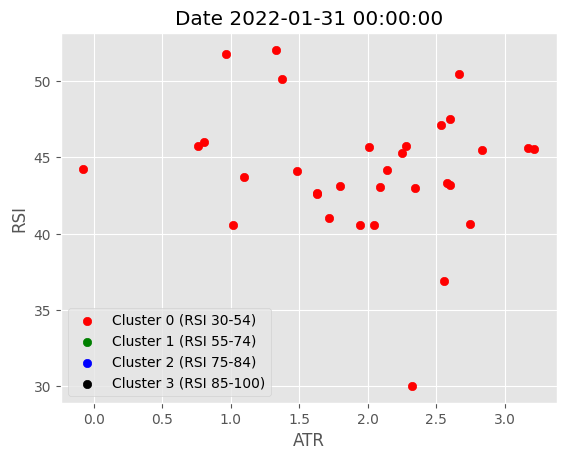

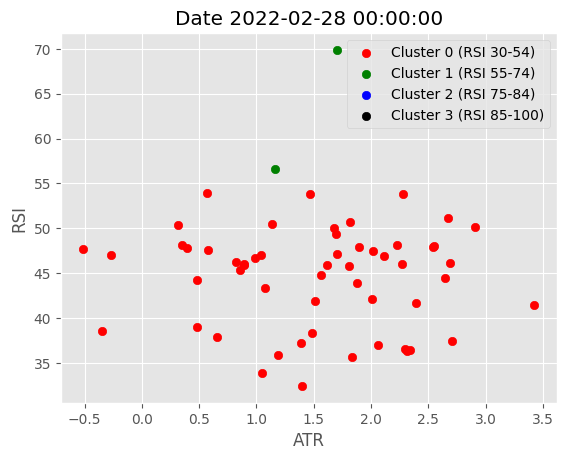

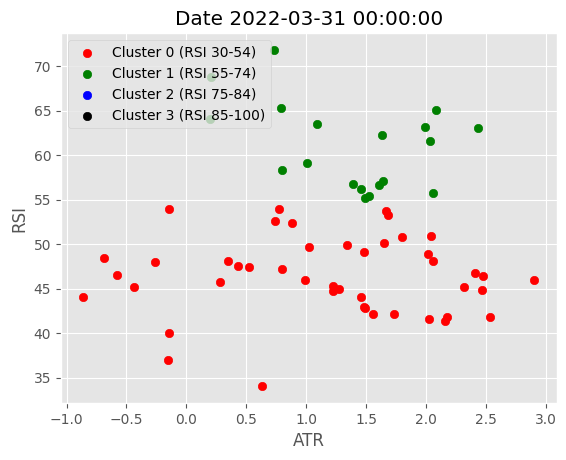

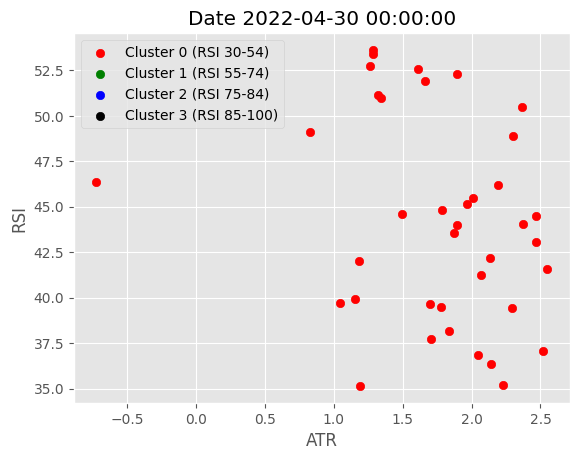

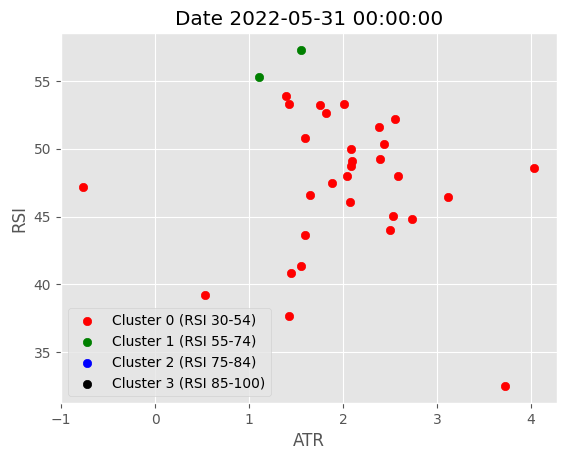

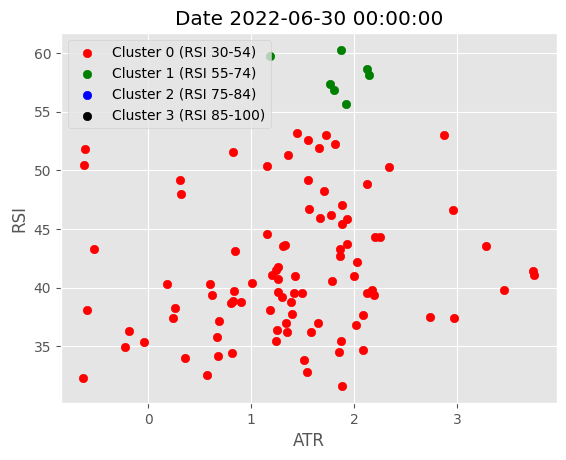

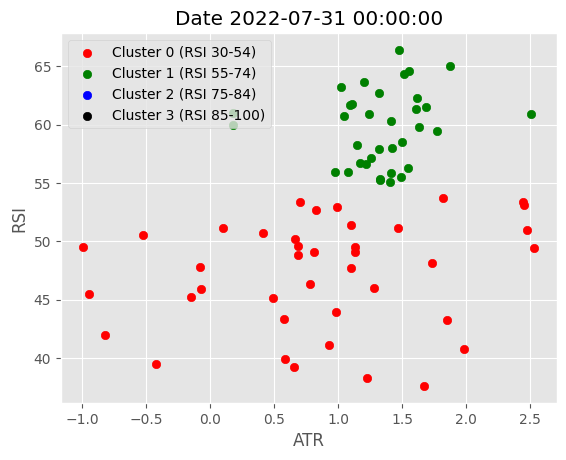

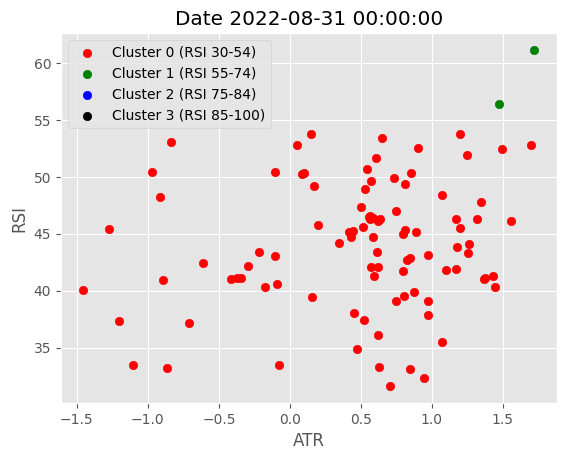

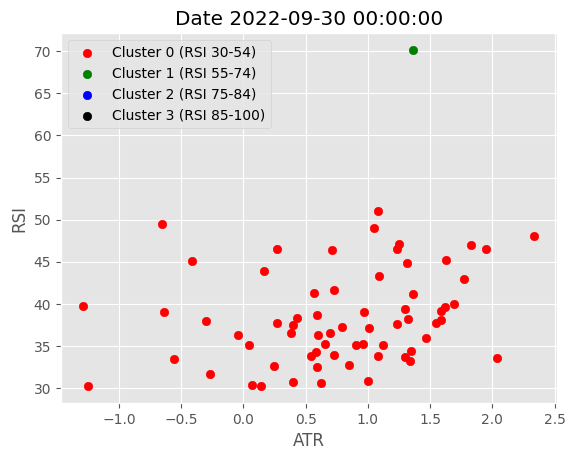

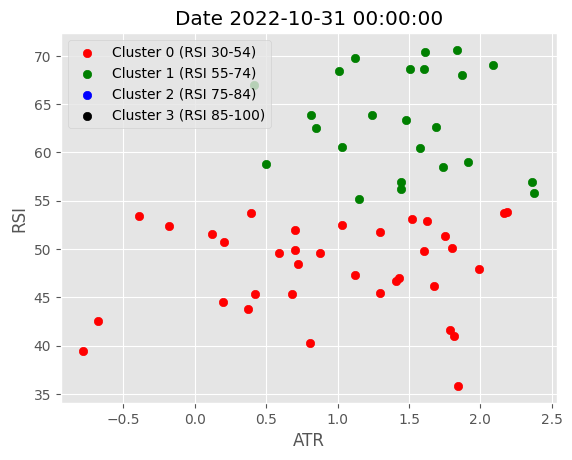

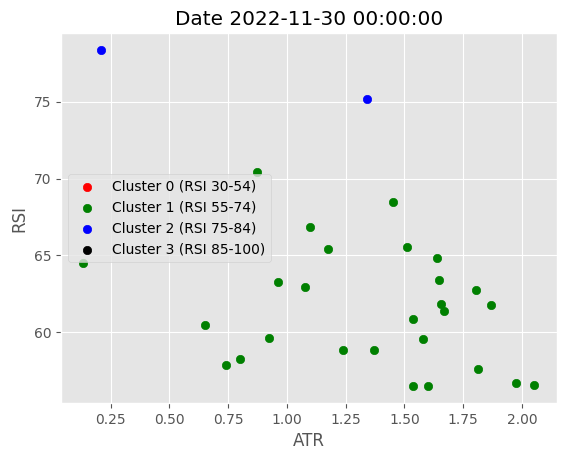

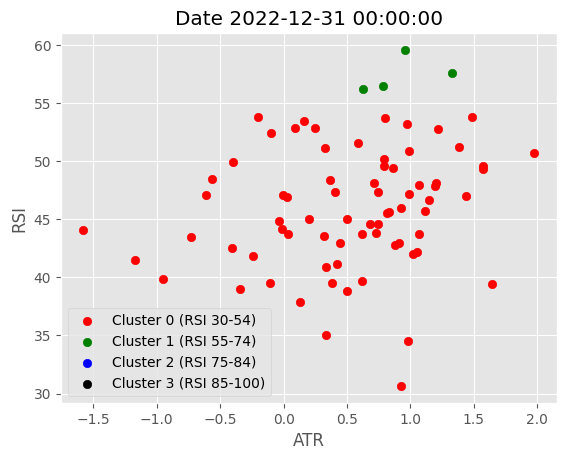

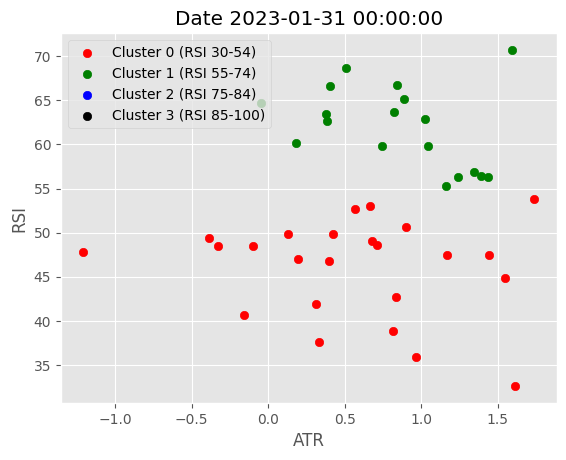

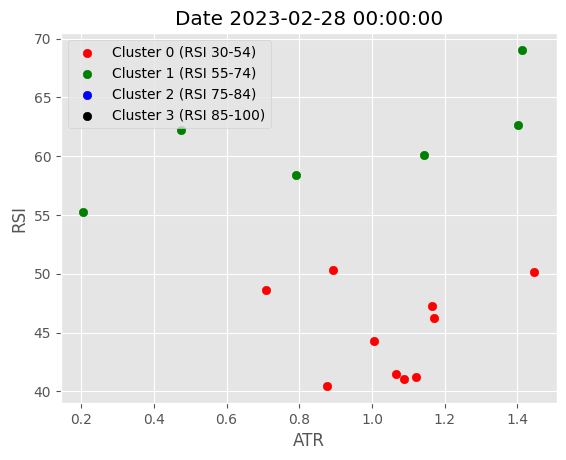

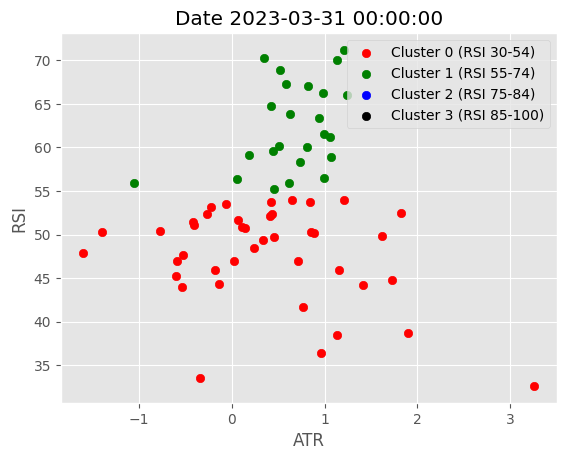

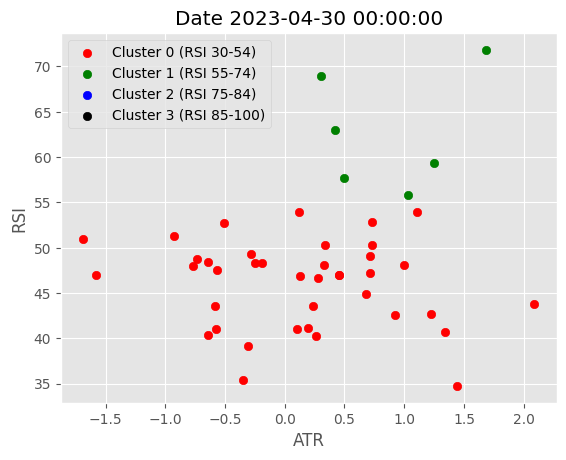

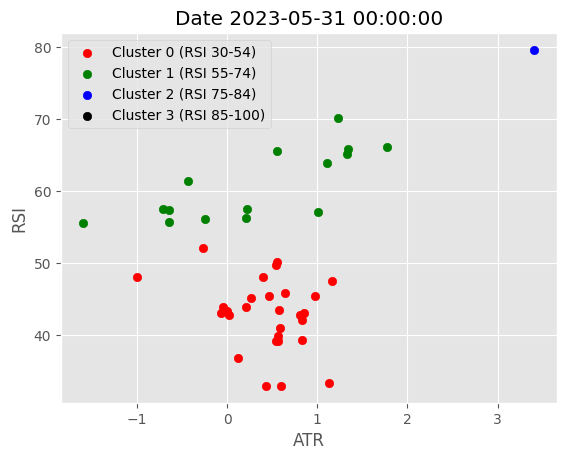

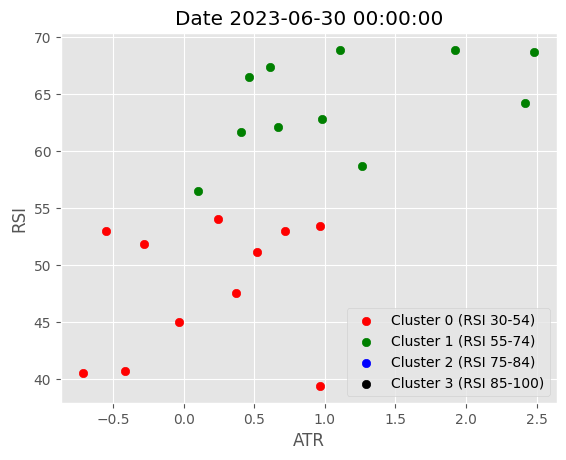

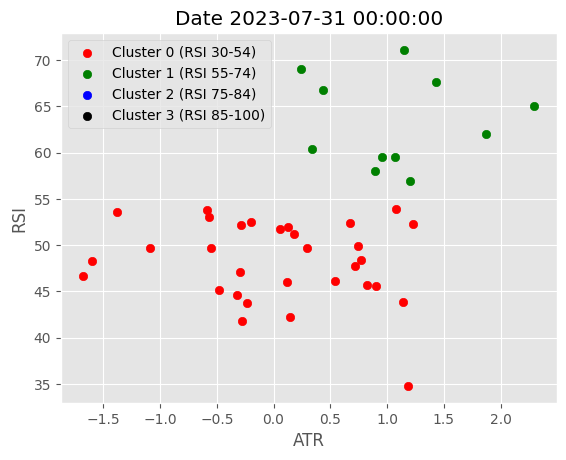

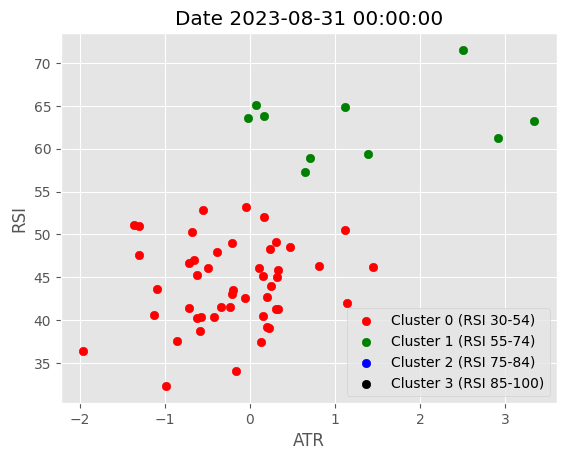

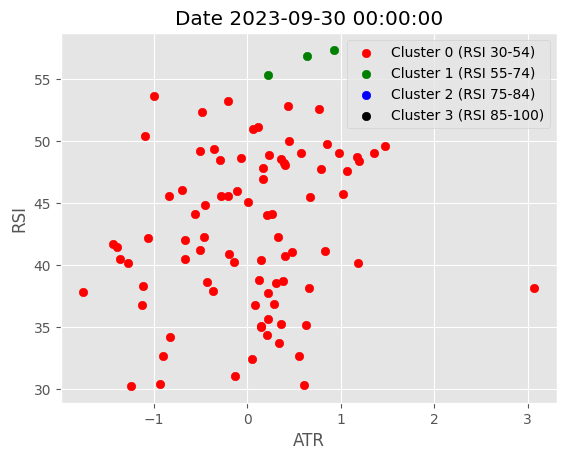

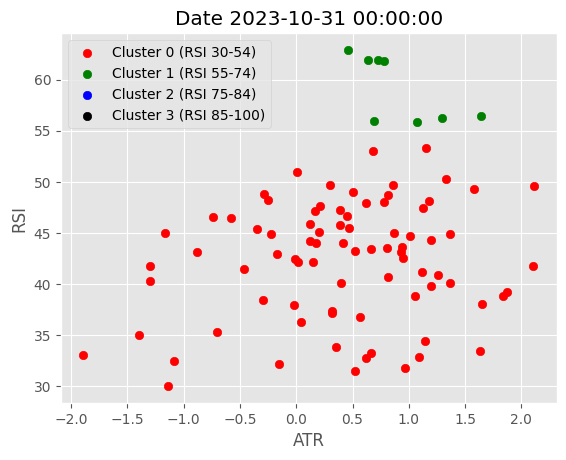

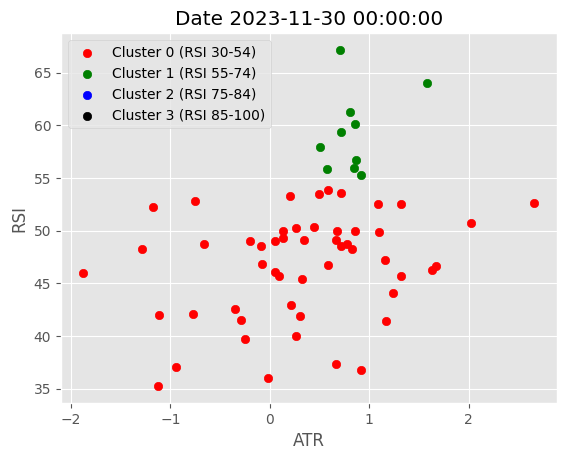

In [298]:
plt.style.use('ggplot')

for i in df.index.get_level_values('date').unique().tolist():
    c = df.xs(i, level=0)
    x_column = df.columns.get_loc('atr')
    y_column = df.columns.get_loc('rsi')
    x_label = f'{df.columns[x_column]}'.upper()
    y_label = f'{df.columns[y_column]}'.upper()

    plt.title(f'Date {i}')
    plot_clusters(c, x_column, y_column, x_label, y_label)

## Selecting High Performance Culsters

In [299]:
hps = df[df['clusters'] == 3].copy()

In [300]:
hps

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-11-30 BKNG    1248.849976          0.000159  39.712707  7.065489   
2015-12-31 BIIB     306.350006          0.000055  57.660455  5.619911   
           CMG      479.850006          0.000114  28.439601  6.154062   
           REGN     542.869995          0.000108  48.767156  6.269493   
2016-01-31 BKNG    1064.969971          0.000757  34.513583  6.920955   
...                        ...               ...        ...       ...   
2023-10-31 AZO     2477.129883          0.000043  46.440111  7.778917   
           CMG     1942.199951          0.000326  58.745893  7.478798   
2023-11-30 AZO     2574.540039          0.000146  55.405089  7.778837   
           BKNG    2858.750000          0.000414  45.129172  7.887601   
           CMG     2040.530029          0.000082  66.638721  7.454067   

                     bb_mid   bb_high       atr      macd  return_1_m  \
date       ticker                                                       
2015-11-30 BKNG    7.188184  7.310880 -0.632194 -1.004671   -0.141235   
2015-12-31 BIIB    5.686135  5.752359 -0.707250  0.750813    0.067943   
           CMG     6.277028  6.399995 -0.343929 -1.346010   -0.172030   
           REGN    6.302038  6.334583 -0.196639 -0.401441   -0.002994   
2016-01-31 BKNG    7.028010  7.135066 -0.155264 -1.593687   -0.164697   
...                     ...       ...       ...       ...         ...   
2023-10-31 AZO     7.831907  7.884896  1.572584 -1.449614   -0.024748   
           CMG     7.518608  7.558418  1.414608  0.077172    0.060251   
2023-11-30 AZO     7.832747  7.886656  1.578110 -0.648401    0.039324   
           BKNG    7.963026  8.038451  1.101351 -1.927254    0.024803   
           CMG     7.532067  7.610067  1.419108  1.278082    0.050628   

                   return_2_m  ...  return_6_m  return_9_m  return_12_m  \
date       ticker              ...                                        
2015-11-30 BKNG      0.004835  ...    0.010636    0.001017     0.006155   
2015-12-31 BIIB      0.026901  ...   -0.045044   -0.035022    -0.008513   
           CMG      -0.134265  ...   -0.037887   -0.033249    -0.029169   
           REGN     -0.013111  ...    0.010421    0.020693     0.023616   
2016-01-31 BKNG     -0.076550  ...   -0.025509   -0.016572     0.004469   
...                       ...  ...         ...         ...          ...   
2023-10-31 AZO      -0.010764  ...   -0.012006    0.001732    -0.001853   
           CMG       0.004030  ...   -0.010375    0.018530     0.021858   
2023-11-30 AZO       0.006778  ...    0.012697    0.003872    -0.000144   
           BKNG     -0.037204  ...    0.022004    0.013934     0.026878   
           CMG       0.055429  ...   -0.002907    0.035471     0.019054   

                     Mkt-RF       SMB       HML       RMW       CMA  \
date       ticker                                                     
2015-11-30 BKNG    1.047146 -0.323836  0.564068 -0.212205 -0.465890   
2015-12-31 BIIB    0.608436  0.380931 -0.340047 -0.694830  0.355407   
           CMG     1.331910  0.411804 -1.036253  0.196026  1.015106   
           REGN    0.370174  0.624937 -1.195072  0.058770  0.430301   
2016-01-31 BKNG    1.047146 -0.323836  0.564068 -0.212205 -0.465890   
...                     ...       ...       ...       ...       ...   
2023-10-31 AZO     0.578606  0.440699 -0.189890  1.368838  0.191390   
           CMG     1.331910  0.411804 -1.036253  0.196026  1.015106   
2023-11-30 AZO     0.578606  0.440699 -0.189890  1.368838  0.191390   
           BKNG    1.047146 -0.323836  0.564068 -0.212205 -0.465890   
           CMG     1.331910  0.411804 -1.036253  0.196026  1.015106   

                          RF  clusters  
date       ticker                       
2015-11-30 BKNG    -1.527268         3  
2015-12-31 BIIB    16.431798         3  
           CMG     21.078473         3  
           REGN 

In [301]:
hps = hps.reset_index('ticker')
hps.index = hps.index+pd.DateOffset(1)
hps = hps.reset_index().set_index(['date', 'ticker'])

In [302]:
dates = hps.index.get_level_values('date').unique().tolist()
f_dates = {}
for g in dates:
    f_dates[g.strftime('%Y-%m-%d')] = hps.xs(g, level=0).index.tolist()

In [303]:
f_dates

{'2015-12-01': ['BKNG'],
 '2016-01-01': ['BIIB', 'CMG', 'REGN'],
 '2016-02-01': ['BKNG'],
 '2016-03-01': ['BKNG'],
 '2016-04-01': ['BKNG'],
 '2016-05-01': ['BKNG'],
 '2016-06-01': ['BKNG'],
 '2016-07-01': ['BKNG'],
 '2016-08-01': ['AAL',
  'AAPL',
  'ABBV',
  'ABT',
  'AIG',
  'AMAT',
  'AMZN',
  'AXP',
  'BAC',
  'BAX',
  'BMY',
  'C',
  'CAT',
  'CL',
  'CMCSA',
  'COF',
  'COP',
  'CRM',
  'CSCO',
  'CSX',
  'CTSH',
  'CVS',
  'CVX',
  'DAL',
  'DD',
  'DE',
  'DHR',
  'EBAY',
  'EOG',
  'F',
  'FCX',
  'GILD',
  'GM',
  'GOOG',
  'GOOGL',
  'HAL',
  'HCA',
  'HPQ',
  'INTC',
  'ISRG',
  'JPM',
  'KMI',
  'KO',
  'KR',
  'LLY',
  'LOW',
  'LUV',
  'LVS',
  'LYB',
  'MDLZ',
  'MDT',
  'MET',
  'MGM',
  'MO',
  'MPC',
  'MRK',
  'MRO',
  'MS',
  'MSFT',
  'MU',
  'NEE',
  'NKE',
  'NXPI',
  'ORCL',
  'OXY',
  'PANW',
  'PARA',
  'PFE',
  'PG',
  'PM',
  'QCOM',
  'RTX',
  'SBUX',
  'SCHW',
  'SLB',
  'SWKS',
  'T',
  'TGT',
  'TJX',
  'TSLA',
  'TXN',
  'UAL',
  'UNP',
  'USB',
  'V',

## Definig portofolio optimization using PyPortofolio and EfficientFrontier to maximize the sharp ratio

In [304]:
def optimized_weights(prices, lower_bound=None):
    returns = expected_returns.mean_historical_return(prices=prices, frequency=252)
    cov = risk_models.sample_cov(prices=prices, frequency=252)

    # Set the lower_bound to a default value if it's None
    if lower_bound is None:
        lower_bound = 0.0  # You can adjust the default value as needed
    # if upper_bound is None:
    #     upper_bound = 0.1
    ef = EfficientFrontier(expected_returns=returns, cov_matrix=cov, weight_bounds=(lower_bound, .1), solver='SCS')
    weights = ef.max_sharpe()
    return ef.clean_weights()

- Downloading fresh prices for shortlisted stocks

In [305]:
stocks = hps.index.get_level_values('ticker').unique().tolist()
new_df = yf.download(tickers=stocks,
                     start = hps.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=hps.index.get_level_values('date').unique()[-1])

[*********************100%%**********************]  152 of 152 completed


In [306]:
returns_df = np.log(new_df['Adj Close']).diff()
portfolio_df = pd.DataFrame()

for j in f_dates.keys():
    try:
        e_date = (pd.to_datetime(j)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = f_dates[j]
        optimized_s = (pd.to_datetime(j)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimized_e = (pd.to_datetime(j)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        optimized_df = new_df[optimized_s:optimized_e]['Adj Close'][cols]

        success = False

        try:
            lower_bound = round(1/len(optimized_df.columns)*2,6) / 100
        # upper_bound = round(1/len(optimized_df.columns), 6) // 100
            weights = optimized_weights(prices=optimized_df,
                                    lower_bound= lower_bound,
                                    )
            weights = pd.DataFrame(weights, index=pd.Series(0))
            success = True
        except:
             print(f'Max Sharpe OPT Failied for {j}, Continuing with Equal-Weights')
        if success == False:
             weights = pd.DataFrame([1/len(optimized_df.columns) for i in range(len(optimized_df.columns))],
                                    index=optimized_df.columns.tolist(),
                                    columns=pd.Series(0)
                                    ).T
        temp_df = returns_df[j : e_date]
        temp_df = temp_df.stack().to_frame('return').reset_index('Date')\
            .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                left_index=True,
                right_index=True)\
            .reset_index().set_index(['Date', 'index']).unstack().stack()
        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy_Return')
        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
        # print(j)
        # print(e_date)
        # print(cols)
        # print(optimized_s)
        # print(optimized_e)
    except Exception as e:
            print(e)       
portfolio_df = portfolio_df.drop_duplicates()

Max Sharpe OPT Failied for 2015-12-01, Continuing with Equal-Weights
Max Sharpe OPT Failied for 2016-01-01, Continuing with Equal-Weights
Max Sharpe OPT Failied for 2016-02-01, Continuing with Equal-Weights
Max Sharpe OPT Failied for 2016-03-01, Continuing with Equal-Weights
Max Sharpe OPT Failied for 2016-04-01, Continuing with Equal-Weights
Max Sharpe OPT Failied for 2016-05-01, Continuing with Equal-Weights
Max Sharpe OPT Failied for 2016-06-01, Continuing with Equal-Weights
Max Sharpe OPT Failied for 2016-07-01, Continuing with Equal-Weights
Max Sharpe OPT Failied for 2016-09-01, Continuing with Equal-Weights
Max Sharpe OPT Failied for 2016-10-01, Continuing with Equal-Weights
Max Sharpe OPT Failied for 2016-11-01, Continuing with Equal-Weights
Max Sharpe OPT Failied for 2016-12-01, Continuing with Equal-Weights
Max Sharpe OPT Failied for 2017-01-01, Continuing with Equal-Weights
Max Sharpe OPT Failied for 2017-02-01, Continuing with Equal-Weights
Max Sharpe OPT Failied for 2017-04

<Axes: xlabel='date'>

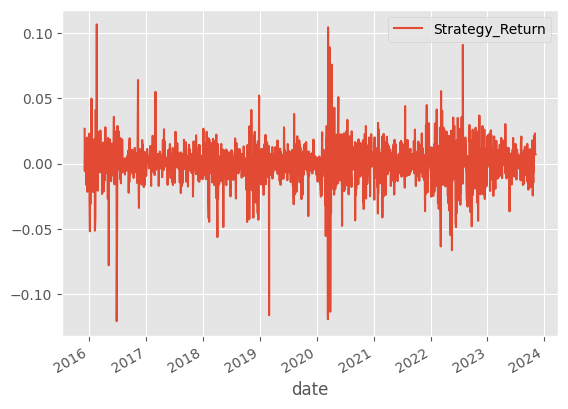

In [307]:
portfolio_df.plot()

## downloading SP500 from YFinance and viualize againest the portofolio

In [308]:
spy = yf.download(tickers='SPY',
                  start = start_date,
                  end= today)

[*********************100%%**********************]  1 of 1 completed


In [309]:
spy_returns_df = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close': 'SPY_Benchmark'}, axis=1)

In [310]:
portfolio_df = portfolio_df.merge(spy_returns_df, left_index=True, right_index=True)

In [311]:
portfolio_cum_return = np.exp(np.log1p(portfolio_df).cumsum())-1

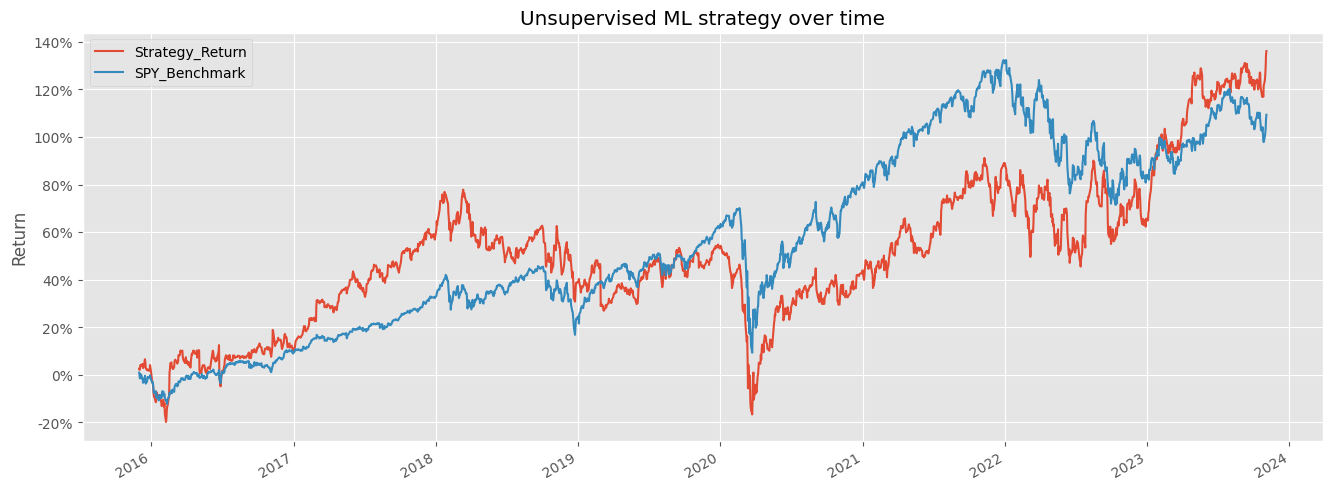

In [312]:
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

# Create the plot
portfolio_cum_return[:'2023-11-06'].plot(figsize=(16, 6))

# Apply y-axis formatting
plt.title('Unsupervised ML strategy over time')
plt.ylabel('Return')
formatter = mtick.FuncFormatter(lambda x, pos: '{:.0%}'.format(x))
plt.gca().yaxis.set_major_formatter(formatter)
